# Loading and concatenating the dataset

In [2]:
import scanpy as sc
import pandas as pd
import os
import matplotlib as plt
import anndata as ad

In [6]:
per0 = sc.read_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/plate3_pre_scrublet_per0.h5ad")

In [7]:
plate3_1 = sc.read_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/plate3_pre_scrublet_WT_plate3_1.h5ad")

In [8]:
plate3_2 = sc.read_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/plate3_pre_scrublet_WT_plate3_2.h5ad")

In [9]:
plate1_4 = sc.read_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/plate1_4_combined.h5ad")

In [211]:
per0_2 = sc.read_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/plate4_pernull_row9_pre_scrublet.h5ad")

In [214]:
# Concatenate datasets along the obs (cells) axis
adata = ad.concat([per0, plate3_1, plate3_2, plate1_4, per0_2], axis=0, join='outer')

In [215]:
# Check if var (gene) indices are unique
print(adata.obs.index.is_unique)  # Should return True

# Check for duplicate indices in var
print(adata.obs.index[adata.obs.index.duplicated()])

# Check if obs (cell) indices are unique
print(adata.var.index.is_unique)  # Should return True



True
Index([], dtype='object', name='sample')
True


In [27]:
adata

AnnData object with n_obs × n_vars = 773573 × 17894
    obs: 'Unmatched_rate', 'UMI_count', 'Gene_count', 'PCR_batch', 'Ligation_barcodes', 'ShortdT_UMI_count', 'RandomN_UMI_count', 'RT_barcodes_shortdT', 'Plate_ID', 'order_bc', 'row', 'col', 'barcode', 'Conditions', 'priming', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'RT_barcode'
    layers: 'counts'

In [230]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_pre_scrublet.h5ad")

# Scrublet

In [231]:
def doublet_detection(adata, expected_doublet_rate=0.08):
    import scrublet as scr
    min_counts = 3
    min_cells = 3
    vscore_percentile = 85
    n_pc = 30
    sim_doublet_ratio = 2
    n_neighbors = 30
    counts_matrix= adata.X
    print(counts_matrix.shape)
    scrub_combined_log = scr.Scrublet(counts_matrix, 
                         expected_doublet_rate=expected_doublet_rate,
                         sim_doublet_ratio=sim_doublet_ratio,
                         n_neighbors=n_neighbors)
    scrub_combined_log.scrub_doublets(min_counts=min_counts,min_cells=min_cells, 
                                    min_gene_variability_pctl=vscore_percentile,n_prin_comps=n_pc,
                                      log_transform=True,mean_center=False,normalize_variance=False)
    scrub_combined_log.plot_histogram();
    return scrub_combined_log
def doublet_identification_pipeline_scrublet_only(adata,output_diretory):
    import numpy as np
    import pandas as pd
    import scanpy as sc
    import anndata as ad
    import matplotlib.pyplot as plt
    import seaborn as sns
    #plt.style.use('seaborn-whitegrid')
    import os
    import math
    sc.settings.verbosity = 3          
    sc.settings.set_figure_params(dpi=80, facecolor='white')
    adata_uncleaned = adata.copy()
    ## doublet score cutoff for scrublet
    doublet_score_threshold = 0.2
    main_clustering_resolution = 0.5
    sub_clustering_resolution = 2
    ## doublet score cutoff for subclustering analysis
    if os.path.exists(output_diretory)==False:
        print("Creating output directory:{}".format(output_diretory))
        os.makedirs(output_diretory)
    else:
        print("Directory already exits:{}".format(output_diretory))
    os.chdir(output_diretory)

    ## doublet detection with scrublet
    scrub_combined_log = doublet_detection(adata_uncleaned, expected_doublet_rate=0.08)
    os.path.join(output_diretory,'test.png')
    scrub_combined_log.call_doublets(doublet_score_threshold)
    scrub_combined_log.plot_histogram();
    plt.savefig(os.path.join(output_diretory,'Doublet_score_histogram.pdf'))
    doublet_scores = scrub_combined_log.doublet_scores_obs_
    simulated_scores = scrub_combined_log.doublet_scores_sim_
    adata_uncleaned.obs['doublet_scores'] = doublet_scores
    np.savetxt('doublet_scores.txt', doublet_scores, delimiter=',')
    np.savetxt('doublet_scores_simulated.txt', simulated_scores, delimiter=',')
    
    adata_uncleaned.obs['doublet'] = adata_uncleaned.obs['doublet_scores'] > doublet_score_threshold
    adata_uncleaned.obs['doublet'] = adata_uncleaned.obs['doublet'].astype(str).astype('category')

    df_cell_scrublet = adata_uncleaned.obs
    df_cell_scrublet.to_csv("df_cell_after_scrublet.csv")
    
    return adata_uncleaned



In [232]:
doublet_detection(adata, expected_doublet_rate=0.08)

(797870, 17893)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using Truncated SVD...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.4%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 3.9%
Elapsed time: 864.1 seconds


In [233]:
doublet_identification_pipeline_scrublet_only(adata, "/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22")

Directory already exits:/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22
(797870, 17893)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using Truncated SVD...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.4%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 3.9%
Elapsed time: 840.8 seconds
Detected doublet rate = 8.7%
Estimated detectable doublet fraction = 57.2%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 15.2%


AnnData object with n_obs × n_vars = 797870 × 17893
    obs: 'Unmatched_rate', 'UMI_count', 'Gene_count', 'PCR_batch', 'Ligation_barcodes', 'ShortdT_UMI_count', 'RandomN_UMI_count', 'RT_barcodes_shortdT', 'Plate_ID', 'order_bc', 'row', 'col', 'barcode', 'Conditions', 'priming', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'RT_barcode', 'doublet_scores', 'doublet'
    var: 'old_gene_id', 'FB_number', 'gene_short_name'
    layers: 'counts'

In [234]:
df_cell = pd.read_csv("df_cell_after_scrublet.csv")

/tmp/ipykernel_19460/3538625595.py:1: DtypeWarning: Columns (13,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cell = pd.read_csv("df_cell_after_scrublet.csv")


In [235]:
adata.obs = df_cell.copy()

In [237]:
adata.obs['doublet_scores'].describe()

count    797870.000000
mean          0.055430
std           0.092546
min           0.000478
25%           0.001463
50%           0.011190
75%           0.066125
max           0.798246
Name: doublet_scores, dtype: float64

In [238]:
adata = adata[adata.obs['doublet_scores'] < 0.1].copy()

/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Concatenation with older data

In [242]:
seu = sc.read_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2024:11:20/old.seu.h5ad")

In [245]:
# Concatenate datasets along the obs (cells) axis
adata = ad.concat([adata, seu], axis=0, join='outer').copy()

In [248]:
adata

AnnData object with n_obs × n_vars = 1010796 × 17929
    obs: 'sample', 'Unmatched_rate', 'UMI_count', 'Gene_count', 'PCR_batch', 'Ligation_barcodes', 'ShortdT_UMI_count', 'RandomN_UMI_count', 'RT_barcodes_shortdT', 'Plate_ID', 'order_bc', 'row', 'col', 'barcode', 'Conditions', 'priming', 'sample.1', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'RT_barcode', 'doublet_scores', 'doublet', 'unsup_celltype'
    layers: 'counts'

# Fixing the gene names to remove greek letters

In [25]:
import re
# Define a regular expression pattern for Greek letters
greek_letters_pattern = r'[\u0370-\u03FF]'
# Check for Greek letters in the index or specific columns of adata.var
contains_greek = adata.var.index.str.contains(greek_letters_pattern)
# Optionally, if checking specific columns
# contains_greek = adata.var['some_column_name'].str.contains(greek_letters_pattern, na=False)
# Display rows with Greek letters
greek_rows = adata.var[contains_greek]
print(greek_rows)

                     gene_short_name
18SrRNA-Ψ:CR45861  18SrRNA-Ψ:CR45861
28SrRNA-Ψ:CR45862  28SrRNA-Ψ:CR45862
2SrRNA-Ψ:CR40677    2SrRNA-Ψ:CR40677
2SrRNA-Ψ:CR45850    2SrRNA-Ψ:CR45850
2SrRNA-Ψ:CR45858    2SrRNA-Ψ:CR45858
5SrRNA-Ψ:CR33356    5SrRNA-Ψ:CR33356
5SrRNA-Ψ:CR33416    5SrRNA-Ψ:CR33416
Ca-β                            Ca-β
Cec-Ψ1                        Cec-Ψ1
His-Ψ:CR31615          His-Ψ:CR31615
His-Ψ:CR31616          His-Ψ:CR31616
His-Ψ:CR31754          His-Ψ:CR31754
His-Ψ:CR33802          His-Ψ:CR33802
His-Ψ:CR33811          His-Ψ:CR33811
Impβ11                        Impβ11
Lcp65AΨ                      Lcp65AΨ
Mst77Y-8Ψ                  Mst77Y-8Ψ
Pkcδ                            Pkcδ
Prosα1R                      Prosα1R
SrpRα                          SrpRα
Sry-α                          Sry-α
Sry-β                          Sry-β
eEF1α1                        eEF1α1
snoRNA:Ψ18S-525c    snoRNA:Ψ18S-525c
tRNA:Glu-CTC-6-1Ψ  tRNA:Glu-CTC-6-1Ψ
tRNA:His-GTG-2-1Ψ  tRNA:His-GTG-2-1Ψ
t

In [29]:
# Define the replacements for Greek letters
replacements = {
    "α": "alpha",
    "β": "beta",
    "Ψ": "Psi",
    "δ": "delta",
    "γ": "gamma"
}
# Apply replacements to each column in adata.var
for column in adata.var.columns:
    if adata.var[column].dtype == 'object':  # Only process string columns
        for greek_letter, replacement in replacements.items():
            adata.var[column] = adata.var[column].str.replace(greek_letter, replacement, regex=True)
# Optionally, verify the changes
print(adata.var)

                         gene_short_name
128up                              128up
14-3-3epsilon              14-3-3epsilon
14-3-3zeta                    14-3-3zeta
140up                              140up
18SrRNA-Psi:CR41602  18SrRNA-Psi:CR41602
...                                  ...
zye                                  zye
βGlu                             betaGlu
βTub56D                       betaTub56D
βTub60D                       betaTub60D
γTry                            gammaTry

[17929 rows x 1 columns]


In [34]:
# Check if var (gene) indices are unique
print(adata.var.index.is_unique)  # Should return True
# Check for duplicate indices in var
print(adata.var.index[adata.var.index.duplicated()])
# Check if obs (cell) indices are unique
print(adata.obs.index.is_unique)  # Should return True

False
Index(['Ca-beta', 'Impbeta11', 'Pkcdelta', 'eEF1alpha1', 'betaGlu',
       'betaTub56D', 'betaTub60D'],
      dtype='object', name='gene_short_name')
True


In [35]:
# Identify duplicate gene names in var.index
duplicate_genes = adata.var.index[adata.var.index.duplicated()]
print(f"Number of duplicate genes: {len(duplicate_genes)}")
print(f"Duplicate genes: {duplicate_genes}")

Number of duplicate genes: 7
Duplicate genes: Index(['Ca-beta', 'Impbeta11', 'Pkcdelta', 'eEF1alpha1', 'betaGlu',
       'betaTub56D', 'betaTub60D'],
      dtype='object', name='gene_short_name')


In [36]:
import numpy as np
from scipy.sparse import csr_matrix, issparse

# Step 1: Identify duplicate gene names
duplicate_genes = adata.var.index[adata.var.index.duplicated()].unique()

# Step 2: Iterate over each duplicate gene and process it
for gene in duplicate_genes:
    # Get all duplicate entries of the current gene
    duplicate_indices = np.where(adata.var.index == gene)[0]

    if len(duplicate_indices) > 1:
        # Aggregate counts from all duplicates
        aggregated_counts = adata[:, duplicate_indices].X.sum(axis=1)

        # Create a mask to keep only the first occurrence
        keep_mask = np.ones(adata.var.shape[0], dtype=bool)
        keep_mask[duplicate_indices[1:]] = False  # Remove duplicates except the first

        # Apply the mask to remove duplicate entries
        adata._inplace_subset_var(keep_mask)

        # Update counts in the first occurrence
        if issparse(adata.X):
            aggregated_counts = csr_matrix(aggregated_counts.reshape(-1, 1))  # Ensure 2D
            adata[:, duplicate_indices[0]].X = aggregated_counts
        else:
            adata[:, duplicate_indices[0]].X = aggregated_counts[:, None]

print(f"Processed {len(duplicate_genes)} duplicate genes: {list(duplicate_genes)}")


/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Processed 7 duplicate genes: ['Ca-beta', 'Impbeta11', 'Pkcdelta', 'eEF1alpha1', 'betaGlu', 'betaTub56D', 'betaTub60D']


In [42]:
adata.var.index.name = "gene_id"

# Getting the FB numbers back and combining duplicate genes with the same FB names

In [47]:
bdata = sc.read_h5ad('/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_pre_scrublet.h5ad')

In [48]:
bdata

AnnData object with n_obs × n_vars = 797870 × 17893
    obs: 'Unmatched_rate', 'UMI_count', 'Gene_count', 'PCR_batch', 'Ligation_barcodes', 'ShortdT_UMI_count', 'RandomN_UMI_count', 'RT_barcodes_shortdT', 'Plate_ID', 'order_bc', 'row', 'col', 'barcode', 'Conditions', 'priming', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'RT_barcode'
    var: 'old_gene_id', 'FB_number', 'gene_short_name'
    layers: 'counts'

In [53]:
print(adata.var)

                         gene_short_name  FB_number
gene_id                                            
128up                              128up        NaN
14-3-3epsilon              14-3-3epsilon        NaN
14-3-3zeta                    14-3-3zeta        NaN
140up                              140up        NaN
18SrRNA-Psi:CR41602  18SrRNA-Psi:CR41602        NaN
...                                  ...        ...
zpg                                  zpg        NaN
zuc                                  zuc        NaN
zyd                                  zyd        NaN
zye                                  zye        NaN
gammaTry                        gammaTry        NaN

[17922 rows x 2 columns]


In [52]:
print(bdata.var)

                         old_gene_id    FB_number  gene_short_name
gene_id                                                           
mod(mdg4)        FLYBASE:FBgn0002781  FBgn0002781        mod(mdg4)
lncRNA:CR40469   FLYBASE:FBgn0058469  FBgn0058469   lncRNA:CR40469
CG17636          FLYBASE:FBgn0025837  FBgn0025837          CG17636
RhoGAP1A         FLYBASE:FBgn0025836  FBgn0025836         RhoGAP1A
mir-4915         FLYBASE:FBgn0263567  FBgn0263567         mir-4915
...                              ...          ...              ...
mt:ND1           FLYBASE:FBgn0013679  FBgn0013679           mt:ND1
mt:tRNA:Leu-TAG  FLYBASE:FBgn0013698  FBgn0013698  mt:tRNA:Leu-TAG
mt:lrRNA         FLYBASE:FBgn0013686  FBgn0013686         mt:lrRNA
mt:tRNA:Val-TAC  FLYBASE:FBgn0013708  FBgn0013708  mt:tRNA:Val-TAC
mt:srRNA         FLYBASE:FBgn0013688  FBgn0013688         mt:srRNA

[17893 rows x 3 columns]


In [50]:
adata.var['FB_number'] = np.nan

In [60]:
# Map FB_number from bdata to adata where gene_short_name matches
adata.var['FB_number'] = adata.var['gene_short_name'].map(
    bdata.var.set_index('gene_short_name')['FB_number']
)


In [61]:
adata.var

gene_short_name    FB_number
gene_id                                              
128up                              128up          NaN
14-3-3epsilon              14-3-3epsilon  FBgn0020238
14-3-3zeta                    14-3-3zeta  FBgn0004907
140up                              140up  FBgn0010340
18SrRNA-Psi:CR41602  18SrRNA-Psi:CR41602  FBgn0085813
...                                  ...          ...
zpg                                  zpg  FBgn0024177
zuc                                  zuc  FBgn0261266
zyd                                  zyd  FBgn0265767
zye                                  zye  FBgn0036985
gammaTry                        gammaTry  FBgn0010359

[17922 rows x 2 columns]

## replacing greek letters from bdata

In [ ]:
## import re

# Define a regular expression pattern for Greek letters
greek_letters_pattern = r'[\u0370-\u03FF]'

# Check for Greek letters in the index or specific columns of adata.var
contains_greek = bdata.var.index.str.contains(greek_letters_pattern)

# Optionally, if checking specific columns
# contains_greek = adata.var['some_column_name'].str.contains(greek_letters_pattern, na=False)

# Display rows with Greek letters
greek_rows = bdata.var[contains_greek]
print(greek_rows)


In [57]:
# Define the replacements for Greek letters
replacements = {
    "α": "alpha",
    "β": "beta",
    "Ψ": "Psi",
    "δ": "delta",
    "γ": "gamma"
}

# Apply replacements to each column in adata.var
for column in adata.var.columns:
    if bdata.var[column].dtype == 'object':  # Only process string columns
        for greek_letter, replacement in replacements.items():
            bdata.var[column] = bdata.var[column].str.replace(greek_letter, replacement, regex=True)

# Optionally, verify the changes
print(bdata.var)


                         old_gene_id    FB_number  gene_short_name
gene_id                                                           
mod(mdg4)        FLYBASE:FBgn0002781  FBgn0002781        mod(mdg4)
lncRNA:CR40469   FLYBASE:FBgn0058469  FBgn0058469   lncRNA:CR40469
CG17636          FLYBASE:FBgn0025837  FBgn0025837          CG17636
RhoGAP1A         FLYBASE:FBgn0025836  FBgn0025836         RhoGAP1A
mir-4915         FLYBASE:FBgn0263567  FBgn0263567         mir-4915
...                              ...          ...              ...
mt:ND1           FLYBASE:FBgn0013679  FBgn0013679           mt:ND1
mt:tRNA:Leu-TAG  FLYBASE:FBgn0013698  FBgn0013698  mt:tRNA:Leu-TAG
mt:lrRNA         FLYBASE:FBgn0013686  FBgn0013686         mt:lrRNA
mt:tRNA:Val-TAC  FLYBASE:FBgn0013708  FBgn0013708  mt:tRNA:Val-TAC
mt:srRNA         FLYBASE:FBgn0013688  FBgn0013688         mt:srRNA

[17893 rows x 3 columns]


In [58]:
bdata.var

old_gene_id    FB_number  gene_short_name
gene_id                                                           
mod(mdg4)        FLYBASE:FBgn0002781  FBgn0002781        mod(mdg4)
lncRNA:CR40469   FLYBASE:FBgn0058469  FBgn0058469   lncRNA:CR40469
CG17636          FLYBASE:FBgn0025837  FBgn0025837          CG17636
RhoGAP1A         FLYBASE:FBgn0025836  FBgn0025836         RhoGAP1A
mir-4915         FLYBASE:FBgn0263567  FBgn0263567         mir-4915
...                              ...          ...              ...
mt:ND1           FLYBASE:FBgn0013679  FBgn0013679           mt:ND1
mt:tRNA:Leu-TAG  FLYBASE:FBgn0013698  FBgn0013698  mt:tRNA:Leu-TAG
mt:lrRNA         FLYBASE:FBgn0013686  FBgn0013686         mt:lrRNA
mt:tRNA:Val-TAC  FLYBASE:FBgn0013708  FBgn0013708  mt:tRNA:Val-TAC
mt:srRNA         FLYBASE:FBgn0013688  FBgn0013688         mt:srRNA

[17893 rows x 3 columns]

In [ ]:
bdata.var_names = bdata.var['gene_short_name']

## checking the nan values in adata

In [62]:
adata.var

gene_short_name    FB_number
gene_id                                              
128up                              128up          NaN
14-3-3epsilon              14-3-3epsilon  FBgn0020238
14-3-3zeta                    14-3-3zeta  FBgn0004907
140up                              140up  FBgn0010340
18SrRNA-Psi:CR41602  18SrRNA-Psi:CR41602  FBgn0085813
...                                  ...          ...
zpg                                  zpg  FBgn0024177
zuc                                  zuc  FBgn0261266
zyd                                  zyd  FBgn0265767
zye                                  zye  FBgn0036985
gammaTry                        gammaTry  FBgn0010359

[17922 rows x 2 columns]

In [67]:
adata.var.index[adata.var['FB_number'].isna()].tolist()

['128up',
 'AdenoK',
 'Adk1',
 'Adk3',
 'CG1461',
 'CG46491',
 'Datp',
 'Dhc1',
 'Dis3',
 'Dna2',
 'L',
 'PolD3',
 'Pss',
 'Septin1',
 'Septin2',
 'Septin4',
 'Septin5',
 'asRNA:CR46194',
 'ccb',
 'dbf',
 'lncRNA:CR46499',
 'mus302',
 'nan',
 'peo',
 'snoRNA:Me18S-G1358c',
 'snoRNA:Me28S-C993',
 'snoRNA:Or-CD13',
 'snoRNA:Or-CD16',
 'speck',
 'stg1']

In [69]:
# List of gene names with missing FB_number
missing_genes = [
    '128up', 'AdenoK', 'Adk1', 'Adk3', 'CG1461', 'CG46491', 'Datp', 'Dhc1',
    'Dis3', 'Dna2', 'L', 'PolD3', 'Pss', 'Septin1', 'Septin2', 'Septin4',
    'Septin5', 'asRNA:CR46194', 'ccb', 'dbf', 'lncRNA:CR46499', 'mus302',
    'nan', 'peo', 'snoRNA:Me18S-G1358c', 'snoRNA:Me28S-C993', 'snoRNA:Or-CD13',
    'snoRNA:Or-CD16', 'speck', 'stg1'
]

# Corresponding FB_numbers
fb_numbers = [
    'FBgn0010339', 'FBgn0036337', 'FBgn0037995', 'FBgn0026602', 'FBgn0030558',
    'FBgn0287631', 'FBgn0287788', 'FBgn0287844', 'FBgn0039183', 'FBgn0288690',
    'FBgn0288433', 'FBgn0283467', 'FBgn0287585', 'FBgn0011710', 'FBgn0014029',
    'FBgn0259923', 'FBgn0026361', 'FBgn0267913', 'FBgn0287645', 'FBgn0287630',
    'FBgn0288701', 'FBgn0287696', 'FBgn0036414', 'FBgn0288856', 'FBgn0286758',
    'FBgn0286739', 'FBgn0286728', 'FBgn0286737', 'FBgn0287831', 'FBgn0288700'
]
# Create a dictionary mapping missing genes to their corresponding FB_number
manual_mapping = dict(zip(missing_genes, fb_numbers))

# Update only the missing FB_number values in adata.var using .replace()
adata.var.loc[adata.var.index.isin(manual_mapping.keys()), 'FB_number'] = (
    adata.var.loc[adata.var.index.isin(manual_mapping.keys()), 'gene_short_name'].replace(manual_mapping)
)

# Verify the update
print(adata.var.loc[adata.var.index.isin(missing_genes), ['gene_short_name', 'FB_number']])


                         gene_short_name    FB_number
gene_id                                              
128up                              128up  FBgn0010339
AdenoK                            AdenoK  FBgn0036337
Adk1                                Adk1  FBgn0037995
Adk3                                Adk3  FBgn0026602
CG1461                            CG1461  FBgn0030558
CG46491                          CG46491  FBgn0287631
Datp                                Datp  FBgn0287788
Dhc1                                Dhc1  FBgn0287844
Dis3                                Dis3  FBgn0039183
Dna2                                Dna2  FBgn0288690
L                                      L  FBgn0288433
PolD3                              PolD3  FBgn0283467
Pss                                  Pss  FBgn0287585
Septin1                          Septin1  FBgn0011710
Septin2                          Septin2  FBgn0014029
Septin4                          Septin4  FBgn0259923
Septin5                     

/tmp/ipykernel_38812/2021679260.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.var.loc[adata.var.index.isin(manual_mapping.keys()), 'gene_short_name'].replace(manual_mapping)


In [71]:
adata.var.index[adata.var['FB_number'].isna()].tolist()

[]

In [72]:
# Identify duplicate gene names in var.index
duplicate_genes = adata.var.index[adata.var['FB_number'].duplicated()]

print(f"Number of duplicate genes: {len(duplicate_genes)}")
print(f"Duplicate genes: {duplicate_genes}")


Number of duplicate genes: 28
Duplicate genes: Index(['Adk2', 'Ady43A', 'CG3809', 'CG46491', 'Datp', 'Dhc1', 'Dna2', 'Gtp-bp',
       'Oaz', 'PolD3', 'Pss', 'Septin1', 'Septin2', 'Septin4', 'Septin5',
       'Tat', 'ccb', 'dbf', 'lncRNA:CR46194', 'lncRNA:CR46499', 'mus302',
       'peo', 'snoRNA:Me18S-G1358c', 'snoRNA:Me28S-C993', 'snoRNA:Or-CD13',
       'snoRNA:Or-CD16', 'speck', 'stg1-1'],
      dtype='object', name='gene_id')


In [74]:
# Find all duplicated FB_numbers
duplicated_fb_numbers = adata.var[adata.var['FB_number'].duplicated(keep=False)]

# Print the result
print(duplicated_fb_numbers.sort_values("FB_number"))


                         gene_short_name    FB_number
gene_id                                              
128up                              128up  FBgn0010339
Gtp-bp                            Gtp-bp  FBgn0010339
Septin1                          Septin1  FBgn0011710
Sep1                                Sep1  FBgn0011710
Septin2                          Septin2  FBgn0014029
Sep2                                Sep2  FBgn0014029
Sep5                                Sep5  FBgn0026361
Septin5                          Septin5  FBgn0026361
Ady43A                            Ady43A  FBgn0026602
Adk3                                Adk3  FBgn0026602
CG1461                            CG1461  FBgn0030558
Tat                                  Tat  FBgn0030558
AdenoK                            AdenoK  FBgn0036337
Adk2                                Adk2  FBgn0036337
Adk1                                Adk1  FBgn0037995
CG3809                            CG3809  FBgn0037995
Septin4                     

In [76]:
pwd

'/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22'

In [80]:
valid_names = pd.read_excel("Book1.xlsx")

In [85]:
# Create a mapping from FB_number to the correct gene name
fb_to_correct_name = valid_names.set_index('ValidatedID')['Relatedrecord'].to_dict()

In [86]:
fb_to_correct_name

{'FBgn0010339': '128up',
 'FBgn0036337': 'Adk2',
 'FBgn0037995': 'Adk1',
 'FBgn0026602': 'Adk3',
 'FBgn0030558': 'Tat',
 'FBgn0287631': 'CG46491',
 'FBgn0287788': 'Datp',
 'FBgn0287844': 'Dhc1',
 'FBgn0039183': 'Dis3',
 'FBgn0288690': 'Dna2',
 'FBgn0288433': 'L',
 'FBgn0283467': 'PolD3',
 'FBgn0287585': 'Pss',
 'FBgn0011710': 'Septin1',
 'FBgn0014029': 'Septin2',
 'FBgn0259923': 'Septin4',
 'FBgn0026361': 'Septin5',
 'FBgn0267913': 'asRNA:CR46194',
 'FBgn0287645': 'ccb',
 'FBgn0287630': 'dbf',
 'FBgn0288701': 'lncRNA:CR46499',
 'FBgn0287696': 'mus302',
 'FBgn0036414': nan,
 'FBgn0288856': 'peo',
 'FBgn0286758': 'snoRNA:CD39c',
 'FBgn0286739': 'snoRNA:CD76',
 'FBgn0286728': 'snoRNA:CD69',
 'FBgn0286737': 'snoRNA:CD75',
 'FBgn0287831': 'speck',
 'FBgn0288700': 'stg1'}

In [91]:
from scipy.sparse import issparse

# Convert 'gene_short_name' to object type to allow new assignments
if isinstance(adata.var['gene_short_name'].dtype, pd.CategoricalDtype):
    adata.var['gene_short_name'] = adata.var['gene_short_name'].astype(str)

# Group by FB_number and aggregate the data
for fb_number, correct_name in fb_to_correct_name.items():
    # Find all rows with the current FB_number
    duplicate_indices = adata.var.index[adata.var['FB_number'] == fb_number]

    if len(duplicate_indices) > 1:
        # Sum the expression values for these duplicate genes across all cells
        aggregated_counts = adata[:, duplicate_indices].X.sum(axis=1)

        # Keep only the first duplicate
        keep_mask = ~adata.var.index.isin(duplicate_indices[1:])
        adata._inplace_subset_var(keep_mask)

        # Rename the first occurrence with the correct name
        adata.var.loc[duplicate_indices[0], 'gene_short_name'] = correct_name

        # Update the expression matrix accordingly
        if issparse(adata.X):
            # Make sure aggregated_counts is in a 2D shape and assign it
            aggregated_counts = aggregated_counts.reshape(-1, 1)  # Ensure 2D
            adata[:, duplicate_indices[0]].X = aggregated_counts
        else:
            adata[:, duplicate_indices[0]].X = aggregated_counts[:, None]

# Verify the update for rows with valid FB_number keys from fb_to_correct_name
print(adata.var.loc[adata.var['FB_number'].isin(fb_to_correct_name.keys()), ['gene_short_name', 'FB_number']])


/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


               gene_short_name    FB_number
gene_id                                    
128up                    128up  FBgn0010339
AANAT1                   speck  FBgn0287831
AdenoK                  AdenoK  FBgn0036337
Adk1                      Adk1  FBgn0037995
Adk3                      Adk3  FBgn0026602
Apf                       Datp  FBgn0287788
CG13025                 mus302  FBgn0287696
CG14579                    ccb  FBgn0287645
CG1461                  CG1461  FBgn0030558
CG17098                    dbf  FBgn0287630
CG2990                    Dna2  FBgn0288690
CG30456                CG46491  FBgn0287631
CG46338                    peo  FBgn0288856
CG4825                     Pss  FBgn0287585
CG9492                    Dhc1  FBgn0287844
Dis3                      Dis3  FBgn0039183
L                            L  FBgn0288433
Pol32                    PolD3  FBgn0283467
Sep1                   Septin1  FBgn0011710
Sep2                   Septin2  FBgn0014029
Sep4                   Septin4  

In [95]:
print(adata.var.loc[adata.var['FB_number'].isin(fb_to_correct_name.keys()), ['gene_short_name', 'FB_number']])

               gene_short_name    FB_number
gene_id                                    
128up                    128up  FBgn0010339
AANAT1                   speck  FBgn0287831
AdenoK                    Adk2  FBgn0036337
Adk1                      Adk1  FBgn0037995
Adk3                      Adk3  FBgn0026602
Apf                       Datp  FBgn0287788
CG13025                 mus302  FBgn0287696
CG14579                    ccb  FBgn0287645
CG1461                  CG1461  FBgn0030558
CG17098                    dbf  FBgn0287630
CG2990                    Dna2  FBgn0288690
CG30456                CG46491  FBgn0287631
CG46338                    peo  FBgn0288856
CG4825                     Pss  FBgn0287585
CG9492                    Dhc1  FBgn0287844
Dis3                      Dis3  FBgn0039183
L                            L  FBgn0288433
Pol32                    PolD3  FBgn0283467
Sep1                   Septin1  FBgn0011710
Sep2                   Septin2  FBgn0014029
Sep4                   Septin4  

In [94]:
adata.var.loc[adata.var['gene_short_name'] == "AdenoK", 'gene_short_name'] = "Adk2"

In [96]:
adata.var.index = adata.var['gene_short_name'].copy()

In [97]:
adata.var.index.name = 'gene_id'

In [98]:
adata.var

gene_short_name    FB_number
gene_id                                              
128up                              128up  FBgn0010339
14-3-3epsilon              14-3-3epsilon  FBgn0020238
14-3-3zeta                    14-3-3zeta  FBgn0004907
140up                              140up  FBgn0010340
18SrRNA-Psi:CR41602  18SrRNA-Psi:CR41602  FBgn0085813
...                                  ...          ...
zpg                                  zpg  FBgn0024177
zuc                                  zuc  FBgn0261266
zyd                                  zyd  FBgn0265767
zye                                  zye  FBgn0036985
gammaTry                        gammaTry  FBgn0010359

[17894 rows x 2 columns]

# Making sure that there are no duplicate genes whatsoever using FB_number

In [ ]:
df.to_excel('/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/df.xlsx')

In [ ]:
adata.var.index = adata.var['gene_short_name'].copy()
adata.var.index.name = 'gene_id'

In [ ]:
print(adata.var.index.duplicated().sum())  # Count the number of duplicate indices
print(adata.var.index[adata.var.index.duplicated()])  # List duplicate indices


In [ ]:
# Make indices unique by appending a suffix
adata.var.index = adata.var.index.where(~adata.var.index.duplicated(), adata.var.index + "_dup")


In [ ]:
from scipy.sparse import issparse

# Clean FB_number column
adata.var['FB_number'] = adata.var['FB_number'].str.strip()

# Correct FB_number and gene_short_name for FBgn0036078
adata.var.loc[adata.var['FB_number'] == 'FBgn0036078', 'FB_number'] = 'FBgn0289868'

# Handle duplicates where FB_number == 'FBgn0289868'
duplicates = adata.var[adata.var['FB_number'] == 'FBgn0289868']
if len(duplicates) > 1:
    print("Duplicate detected. Merging duplicates...")
    duplicate_indices = duplicates.index

    # Aggregate expression values for the duplicates
    aggregated_counts = adata[:, duplicate_indices].X.sum(axis=1)

    # Keep only the first duplicate
    keep_mask = ~adata.var.index.isin(duplicate_indices[1:])
    adata._inplace_subset_var(keep_mask)

    # Assign the aggregated counts to the first duplicate
    if issparse(adata.X):
        aggregated_counts = aggregated_counts.reshape(-1, 1)  # Ensure 2D
        adata[:, duplicate_indices[0]].X = aggregated_counts
    else:
        adata[:, duplicate_indices[0]].X = aggregated_counts[:, None]

# Verify the update
print(adata.var.loc[adata.var['FB_number'] == 'FBgn0289868', ['gene_short_name', 'FB_number']])


In [ ]:
# Remove the suffix "_dup" from the indices if it was added
adata.var.index = adata.var.index.str.replace("_dup", "", regex=False)


In [ ]:
adata

In [ ]:
adata.write_h5ad('/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad')

# Adding other columns

In [8]:
import numpy as np

# Define conditions
conditions = [
    adata.obs['Conditions'].str.contains('M_'),
    adata.obs['Conditions'].str.contains('F_')
]

# Define corresponding values
choices = ['Male', 'Female']

# Create the 'sex' column based on conditions
adata.obs['sex'] = np.select(conditions, choices, default='Mixed')


In [9]:
import numpy as np

# Define conditions
conditions = [
    adata.obs['Conditions'].str.contains('Per', na=False),
    adata.obs['Conditions'].str.contains('MT', na=False),
    adata.obs['Conditions'].str.contains(r'M\d+', na=False),  # Matches 'M' followed by one or more digits
    adata.obs['Conditions'].str.contains('WT', na=False)
]

# Define corresponding values
choices = ['per0', 'per0', 'per0', 'Wild-type']

# Create the 'genotype' column based on conditions
adata.obs['genotype'] = np.select(conditions, choices, default='Unknown')


In [10]:
import numpy as np

# Define conditions
conditions = [
    adata.obs['Conditions'].str.contains('ZT', na=False),
    adata.obs['Conditions'].str.contains('CT', na=False),
    adata.obs['Conditions'].str.contains('DD', na=False)
]

# Define corresponding values
choices = ['LD', 'DD', 'DD']

# Create the 'genotype' column based on conditions
adata.obs['light_condition'] = np.select(conditions, choices, default='LD')


In [11]:
adata

AnnData object with n_obs × n_vars = 1010796 × 17929
    obs: 'sample', 'Unmatched_rate', 'UMI_count', 'Gene_count', 'PCR_batch', 'Ligation_barcodes', 'ShortdT_UMI_count', 'RandomN_UMI_count', 'RT_barcodes_shortdT', 'Plate_ID', 'order_bc', 'row', 'col', 'barcode', 'Conditions', 'priming', 'sample.1', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'RT_barcode', 'doublet_scores', 'doublet', 'unsup_celltype', 'sex', 'genotype', 'light_condition'
    layers: 'counts'

In [103]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

# Getting the batch information

In [163]:
adata = sc.read_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [165]:
adata

AnnData object with n_obs × n_vars = 990897 × 17929
    obs: 'sample', 'Unmatched_rate', 'UMI_count', 'Gene_count', 'PCR_batch', 'Ligation_barcodes', 'ShortdT_UMI_count', 'RandomN_UMI_count', 'RT_barcodes_shortdT', 'Plate_ID', 'order_bc', 'row', 'col', 'barcode', 'Conditions', 'priming', 'sample.1', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'RT_barcode', 'doublet_scores', 'doublet', 'unsup_celltype', 'sex', 'genotype', 'light_condition', 'replicate', 'new_Conditions', 'timepoint'
    layers: 'counts'

In [12]:
adata.obs['batch'] = np.nan

In [18]:
adata.obs['batch'].unique().tolist()

['20250114', '20241216', '20230925', '20230314']

In [14]:
# Now update the values
adata.obs.loc[adata.obs['PCR_batch'].str.contains('20230314', na=False), 'batch'] = '20230314'

/tmp/ipykernel_13527/1541583217.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20230314' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs['PCR_batch'].str.contains('20230314', na=False), 'batch'] = '20230314'


In [15]:
# Now update the values
adata.obs.loc[adata.obs['PCR_batch'].str.contains('20230925', na=False), 'batch'] = '20230925'

In [16]:
# Now update the values
adata.obs.loc[adata.obs['PCR_batch'].str.contains('2024_fly_plate', na=False), 'batch'] = '20241216'

In [17]:
# Now update the values
adata.obs.loc[adata.obs['PCR_batch'].str.contains('2024_male_plate', na=False), 'batch'] = '20250114'

# Fixing the adata.obs.['Conditions']

In [20]:
# Extract the last character if the string ends with '_1' or '_2'
adata.obs['replicate'] = adata.obs['Conditions'].str.extract(r'_(\d)$')

# Handle NaN values by filling them with a default value (e.g., 0)
adata.obs['replicate'] = adata.obs['replicate'].fillna(0).astype(int)


In [21]:
adata.obs['replicate'].unique()

array([0, 1, 2])

In [22]:
adata.obs['new_Conditions'] = adata.obs['Conditions'].copy()

In [23]:
# Remove the trailing '_1' or '_2' from strings in adata.obs['new_Conditions']
adata.obs['new_Conditions'] = adata.obs['new_Conditions'].str.replace(r'_(1|2)$', '', regex=True)


In [25]:
import re

# Function to extract timepoints from strings
def extract_timepoint(condition):
    match = re.search(r'(?<!\d)(\d{1,2}|100)(?!\d)', condition)  # Matches standalone numbers
    return int(match.group(0)) if match else None  # Returns the match or None if no match

# Apply function to create the new 'timepoint' column
adata.obs['timepoint'] = adata.obs['new_Conditions'].apply(extract_timepoint)


# Add the new timepoint column

In [28]:
# Create the new_timepoint column with default "around-the-clock" values
adata.obs['new_timepoint'] = adata.obs['timepoint'] % 24

# Apply the special case for 'DD' condition
adata.obs.loc[
    (adata.obs['light_condition'] == 'DD') & (adata.obs['timepoint'] == 28),
    'new_timepoint'
] = 28

# Print the unique values of the new_timepoint column to confirm
print(adata.obs['new_timepoint'].unique().tolist())


[20, 0, 16, 4, 12, 8, 28]


In [29]:
print(adata.obs['batch'].unique().tolist())

['20250114', '20241216', '20230925', '20230314']


In [35]:
# Assign 1 to 'replicate' for timepoints 0 to 20 in the specific batch
adata.obs.loc[
    (adata.obs['batch'] == '20230925') & (adata.obs['timepoint'].between(48, 68, inclusive='both')),
    'replicate'
] = 3

# Assign 2 to 'replicate' for timepoints 24 to 44 in the specific batch
adata.obs.loc[
    (adata.obs['batch'] == '20230925') & (adata.obs['timepoint'].between(72, 92, inclusive='both')),
    'replicate'
] = 4

In [38]:
# Assign 1 to 'replicate' for timepoints 0 to 20 in the specific batch
adata.obs.loc[
    (adata.obs['batch'] == '20241216') & (adata.obs['timepoint'].between(0, 20, inclusive='both')),
    'replicate'
] = 1

# Assign 2 to 'replicate' for timepoints 24 to 44 in the specific batch
adata.obs.loc[
    (adata.obs['batch'] == '20241216') & (adata.obs['timepoint'].between(24, 44, inclusive='both')),
    'replicate'
] = 2

adata.obs.loc[
    (adata.obs['batch'] == '20241216') & (adata.obs['timepoint'].between(24, 28, inclusive='both'))
    & (adata.obs['light_condition'] == 'DD'),
    'replicate'
] = 1

In [43]:
# Assign 1 to 'replicate' for timepoints 0 to 20 in the specific batch
adata.obs.loc[
    (adata.obs['batch'] == '20250114') & (adata.obs['timepoint'].between(0, 20, inclusive='both')),
    'replicate'
] = 1

# Assign 2 to 'replicate' for timepoints 24 to 44 in the specific batch
adata.obs.loc[
    (adata.obs['batch'] == '20250114') & (adata.obs['timepoint'].between(24, 44, inclusive='both')),
    'replicate'
] = 2

adata.obs.loc[
    (adata.obs['batch'] == '20250114') & (adata.obs['timepoint'].between(24, 28, inclusive='both'))
    & (adata.obs['light_condition'] == 'DD'),
    'replicate'
] = 1

# Adding the final_Conditions column

In [50]:
# Ensure all columns are converted to strings before concatenation
adata.obs['final_Conditions'] = (
    adata.obs['genotype'].astype(str).replace({'per0': 'MT', 'Wild-type': 'WT'}) + '_' +
    adata.obs['sex'].astype(str).replace({'Male': 'Mal', 'Female': 'Fem', 'Mixed': 'Mix'}) + '_' +
    adata.obs['light_condition'].astype(str).replace({'DD': 'CT', 'LD': 'ZT'}) +
    adata.obs['new_timepoint'].astype(str) + '_' +
    adata.obs['replicate'].astype(str)
)

# Check the result
print(adata.obs['final_Conditions'].unique().tolist())


['MT_Mal_ZT20_2', 'MT_Mal_ZT0_2', 'WT_Mal_CT16_1', 'WT_Fem_CT16_1', 'MT_Fem_ZT4_1', 'WT_Fem_CT4_1', 'MT_Fem_ZT0_1', 'WT_Mal_CT12_1', 'MT_Mal_ZT16_1', 'MT_Fem_CT0_1', 'MT_Mal_ZT8_2', 'MT_Fem_ZT12_1', 'WT_Mal_CT20_1', 'MT_Mal_ZT12_1', 'WT_Fem_CT8_1', 'WT_Mal_CT4_1', 'MT_Mal_ZT4_1', 'MT_Fem_ZT8_2', 'WT_Fem_CT20_1', 'MT_Mal_CT0_1', 'WT_Mal_CT0_1', 'MT_Fem_CT8_1', 'MT_Fem_CT16_1', 'MT_Fem_ZT4_2', 'WT_Mal_CT8_1', 'MT_Mal_CT20_1', 'MT_Fem_ZT8_1', 'MT_Fem_CT4_1', 'MT_Mal_CT8_1', 'MT_Mal_CT16_1', 'MT_Fem_ZT12_2', 'MT_Fem_ZT16_1', 'MT_Mal_ZT16_2', 'MT_Mal_ZT0_1', 'MT_Mal_ZT20_1', 'MT_Fem_ZT0_2', 'MT_Mal_CT4_1', 'MT_Fem_CT20_1', 'WT_Fem_CT12_1', 'MT_Mal_ZT8_1', 'WT_Fem_CT0_1', 'MT_Mal_ZT12_2', 'MT_Mal_ZT4_2', 'MT_Fem_ZT16_2', 'MT_Fem_ZT20_1', 'MT_Fem_CT12_1', 'MT_Fem_ZT20_2', 'MT_Mal_CT12_1', 'WT_Mal_ZT8_1', 'WT_Fem_ZT16_2', 'WT_Fem_ZT12_1', 'WT_Fem_ZT12_2', 'WT_Mal_ZT20_1', 'WT_Mal_ZT8_2', 'WT_Fem_ZT4_1', 'WT_Fem_ZT8_1', 'WT_Mal_ZT20_2', 'WT_Mal_ZT16_1', 'WT_Mal_ZT12_2', 'WT_Mal_ZT0_1', 'WT_Mal_

# UMI/ gene count check

In [1]:
import pandas as pd
import scanpy as sc

In [33]:
sc.pp.filter_genes(adata, min_cells=3)

In [34]:
# Apply your custom filters
adata = adata[adata.obs['UMI_count'] >= 200, :]
adata = adata[adata.obs['Gene_count'] >= 100, :]

In [36]:
print(adata.shape)  # (n_cells, n_genes)
adata.obs[['UMI_count', 'Gene_count']].describe()


(1001359, 17198)


UMI_count    Gene_count
count  1.001359e+06  1.001359e+06
mean   1.170896e+03  3.138627e+02
std    1.229790e+03  1.975771e+02
min    2.000000e+02  1.000000e+02
25%    4.850000e+02  1.790000e+02
50%    8.000000e+02  2.600000e+02
75%    1.400000e+03  3.880000e+02
max    7.749300e+04  4.126000e+03

In [44]:
adata.obs[['Unmatched_rate']].describe()

Unmatched_rate
count    1.001359e+06
mean     1.739935e-02
std      1.593464e-02
min      0.000000e+00
25%      8.892703e-03
50%      1.411618e-02
75%      2.110978e-02
max      3.510151e-01

In [45]:
import numpy as np

# Compute total UMIs (if not already present)
if 'n_counts' not in adata.obs:
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else adata.X.sum(axis=1)

# Compute number of genes detected (nonzero per row)
if 'n_genes' not in adata.obs:
    adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1 if hasattr(adata.X, "A1") else (adata.X > 0).sum(axis=1)


/tmp/ipykernel_22405/2210386312.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else adata.X.sum(axis=1)


In [46]:
mean_umis = np.mean(adata.obs['n_counts'])
median_umis = np.median(adata.obs['n_counts'])

mean_genes = np.mean(adata.obs['n_genes'])
median_genes = np.median(adata.obs['n_genes'])

print(f"Average UMIs per nucleus: {mean_umis:,.0f}")
print(f"Median UMIs per nucleus: {median_umis:,.0f}")
print(f"Average genes per nucleus: {mean_genes:,.0f}")
print(f"Median genes per nucleus: {median_genes:,.0f}")


Average UMIs per nucleus: 1,170
Median UMIs per nucleus: 799
Average genes per nucleus: 314
Median genes per nucleus: 260


# UMAP configuration

In [66]:
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import os
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=300, facecolor='white')

def run_clustering_new(adata, n_top_genes, n_neighbors, n_pcs, min_dist, resolution, distance_metric, regress_out_total_counts):
    adata_processed = sc.pp.filter_genes(adata, min_cells=3, copy=True)
    adata_processed.layers['raw_counts'] = adata_processed.X
    sc.pp.normalize_total(adata_processed, target_sum=1e4, key_added="Normalize")
    sc.pp.log1p(adata_processed)
    adata_processed.layers['logNorm'] = adata_processed.X
    adata_processed.raw = adata_processed
    sc.pp.highly_variable_genes(adata_processed, n_top_genes=n_top_genes)
    adata_processed_HVG = adata_processed[:, adata_processed.var['highly_variable'] == True]
    if regress_out_total_counts:
        sc.pp.regress_out(adata_processed_HVG, ['UMI_count'])
    sc.pp.scale(adata_processed_HVG, max_value=10)
    sc.tl.pca(adata_processed_HVG, n_comps = n_pcs, svd_solver='arpack')
    sc.pp.neighbors(adata_processed_HVG, n_neighbors=n_neighbors, n_pcs=n_pcs, metric=distance_metric)
    sc.tl.umap(adata_processed_HVG, min_dist=min_dist)
    #sc.tl.leiden(adata_processed_HVG, resolution=resolution)
    return adata_processed_HVG

output_folder = "/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22"

#These are my settings, the key parameter you can play around with is min_dist (the smaller, the more clustering you will get)
#and the number of neighbors/PCs. I would try first these settings + min_dist = 0.3, to see which is better. Best, Ahmet

In [ ]:
adata_clustered = run_clustering_new(adata, n_top_genes=10000, n_neighbors=50, n_pcs=120,
                                    min_dist=0.01, resolution=0.5, distance_metric="cosine",
                                    regress_out_total_counts=False)

# Save UMAP with Leiden clusters colored
# Save UMAP with Leiden clusters colored
sc.pl.umap(adata_clustered, color="unsup_celltype", title="UMAP with unsup_celltype", legend_loc="on data", legend_fontsize=4, save=f"_test_1.png")

# Retrieve the 2D array of UMAP coordinates
umap_coords = adata_clustered.obsm["X_umap"]

# Create two new columns in `adata_clustered.obs`
adata_clustered.obs["UMAP_1"] = umap_coords[:, 0]
adata_clustered.obs["UMAP_2"] = umap_coords[:, 1]

# Now this CSV includes UMAP coordinates
adata_clustered.obs.to_csv(f"/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/df_cell_post_1fo58_1.csv")

In [62]:
sc.settings.set_figure_params(dpi=300, facecolor='white')

In [ ]:
adata_clustered = run_clustering_new(adata, n_top_genes=10000, n_neighbors=50, n_pcs=120,
                                    min_dist=0.01, resolution=0.5, distance_metric="cosine",
                                    regress_out_total_counts=False)

# Save UMAP with Leiden clusters colored
# Save UMAP with Leiden clusters colored
sc.pl.umap(adata_clustered, color="unsup_celltype", title="UMAP with unsup_celltype", legend_loc="on data", legend_fontsize=4, save=f"_test_1.png")

# Retrieve the 2D array of UMAP coordinates
umap_coords = adata_clustered.obsm["X_umap"]

# Create two new columns in `adata_clustered.obs`
adata_clustered.obs["UMAP_1"] = umap_coords[:, 0]
adata_clustered.obs["UMAP_2"] = umap_coords[:, 1]

# Now this CSV includes UMAP coordinates
adata_clustered.obs.to_csv(f"/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/df_cell_post_1fo58_1.csv")

/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


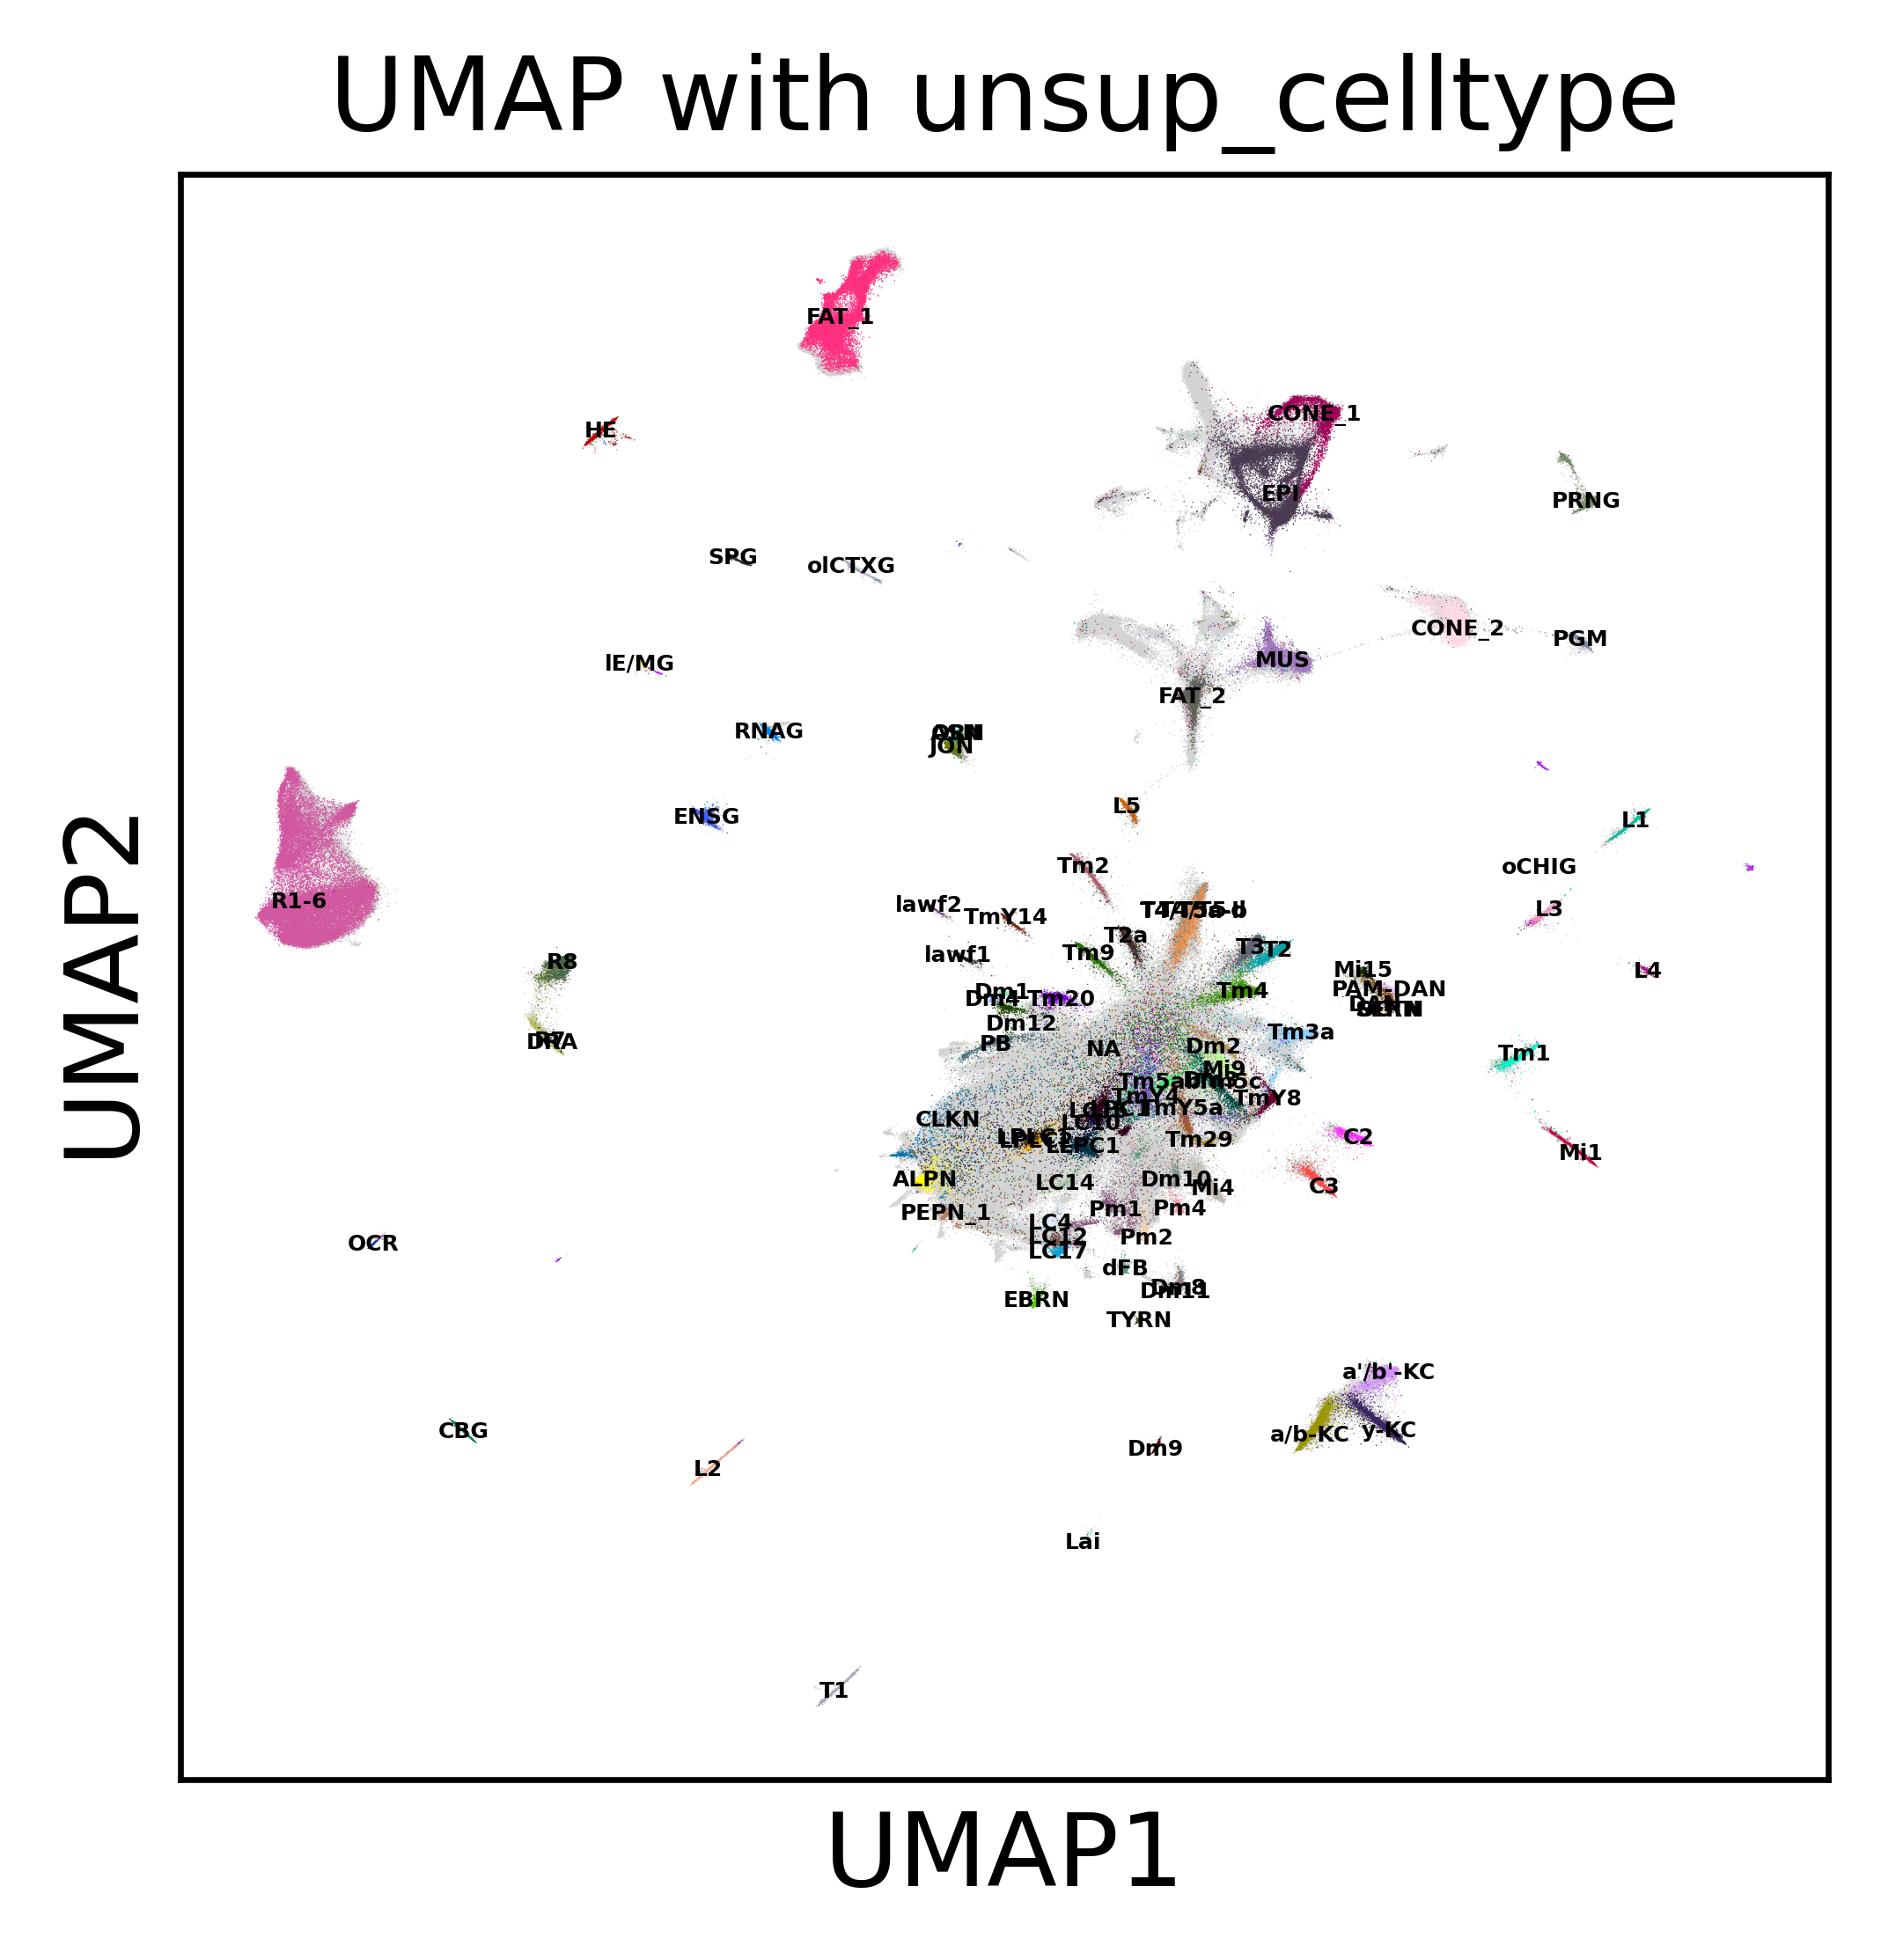

In [77]:
sc.pl.umap(adata_clustered, color="unsup_celltype", title="UMAP with unsup_celltype", legend_loc="on data", legend_fontsize=3, save=f"_test_1_min_dist=0.1.png")

/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


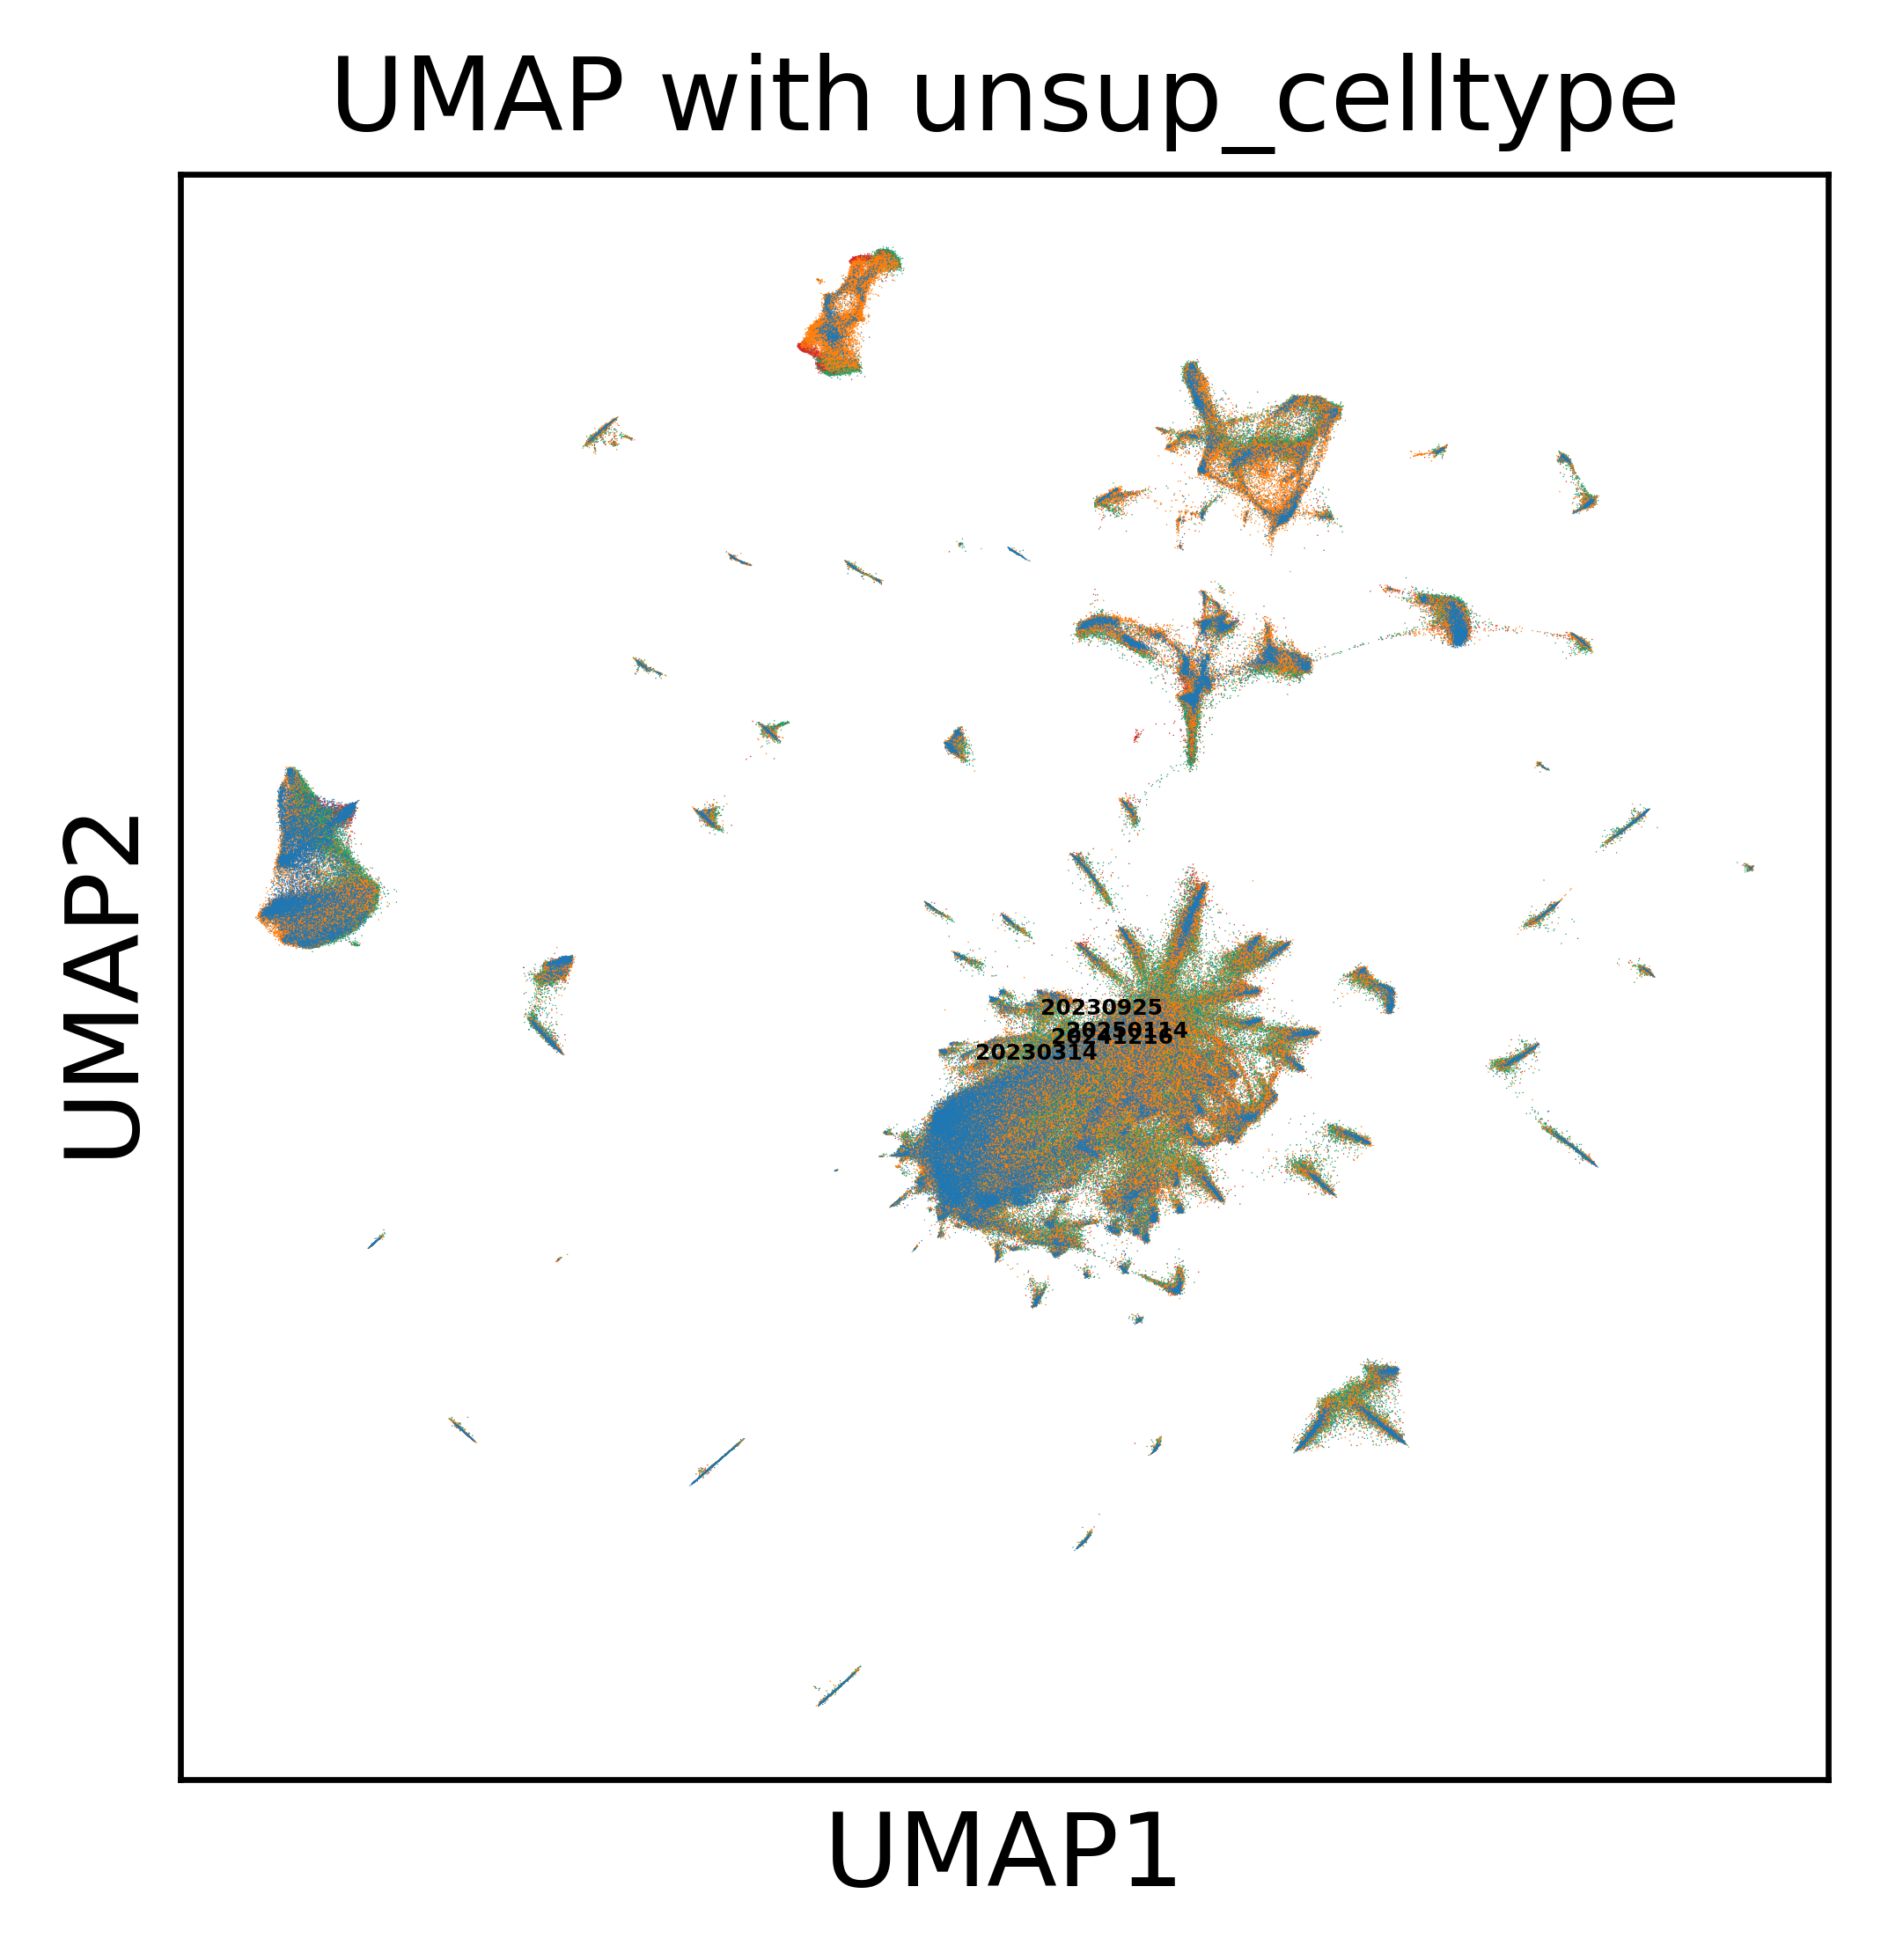

In [81]:
sc.pl.umap(adataadata_clustered, color="batch", title="UMAP with unsup_celltype", legend_loc="on data", legend_fontsize=3) #save=f"_test_1_min_dist=0.1.png")

# New Funtion for optimizing UMAP parameters

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import os

output_folder = "/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31"

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=300, facecolor='white')

def run_clustering_new(adata, n_top_genes, n_neighbors, n_pcs, min_dist, resolution, distance_metric, regress_out_total_counts, save_prefix=""):
    # Preprocessing
    adata_processed = sc.pp.filter_genes(adata, min_cells=3, copy=True)
    adata_processed.layers['raw_counts'] = adata_processed.X
    sc.pp.normalize_total(adata_processed, target_sum=1e4, key_added="Normalize")
    sc.pp.log1p(adata_processed)
    adata_processed.layers['logNorm'] = adata_processed.X
    adata_processed.raw = adata_processed
    sc.pp.highly_variable_genes(adata_processed, n_top_genes=n_top_genes)
    adata_processed_HVG = adata_processed[:, adata_processed.var['highly_variable'] == True]
    
    # Regress out total counts if specified
    if regress_out_total_counts:
        sc.pp.regress_out(adata_processed_HVG, ['UMI_count'])
    sc.pp.scale(adata_processed_HVG, max_value=10)
    
    # PCA, Neighbors, UMAP
    sc.tl.pca(adata_processed_HVG, n_comps=n_pcs, svd_solver='arpack')
    sc.pp.neighbors(adata_processed_HVG, n_neighbors=n_neighbors, n_pcs=n_pcs, metric=distance_metric)
    sc.tl.umap(adata_processed_HVG, min_dist=min_dist)
    
    # Plot UMAP and save with parameters in title and filename
    title = f"UMAP | n_neighbors={n_neighbors}, n_pcs={n_pcs}, min_dist={min_dist:.2f}"
    filename = f"{save_prefix}_n_neighbors{n_neighbors}_n_pcs{n_pcs}_min_dist{min_dist:.2f}.png"
    sc.pl.umap(
        adata_processed_HVG,
        color="unsup_celltype",
        title=title,
        legend_loc="on data",
        legend_fontsize=3,
        save=filename
    )
    
    return adata_processed_HVG


# Leiden Clustering for main cell types

In [31]:
for res in [4.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 81 clusters and added
    'leiden_res_4.00_main', the cluster labels (adata.obs, categorical) (0:33:50)


In [32]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [33]:
for res in [6.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 101 clusters and added
    'leiden_res_6.00_main', the cluster labels (adata.obs, categorical) (0:47:21)


In [34]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [35]:
for res in [0.4]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 30 clusters and added
    'leiden_res_0.40_main', the cluster labels (adata.obs, categorical) (0:23:28)


In [36]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [37]:
for res in [0.6]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 39 clusters and added
    'leiden_res_0.60_main', the cluster labels (adata.obs, categorical) (0:21:05)


In [38]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [ ]:
for res in [0.8]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering


In [ ]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [41]:
for res in [1.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 44 clusters and added
    'leiden_res_1.00_main', the cluster labels (adata.obs, categorical) (0:41:21)


In [42]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [43]:
for res in [1.2]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 47 clusters and added
    'leiden_res_1.20_main', the cluster labels (adata.obs, categorical) (0:23:40)


In [44]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [45]:
for res in [1.4]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 49 clusters and added
    'leiden_res_1.40_main', the cluster labels (adata.obs, categorical) (0:31:09)


In [46]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [47]:
for res in [1.6]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 55 clusters and added
    'leiden_res_1.60_main', the cluster labels (adata.obs, categorical) (0:32:12)


In [48]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [49]:
for res in [1.8]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 58 clusters and added
    'leiden_res_1.80_main', the cluster labels (adata.obs, categorical) (0:37:03)


In [50]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [51]:
for res in [0.05]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res_0.05_main', the cluster labels (adata.obs, categorical) (0:07:26)


In [52]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [53]:
for res in [0.1]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res_0.10_main', the cluster labels (adata.obs, categorical) (0:07:30)


In [54]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [55]:
for res in [0.03]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res_0.03_main', the cluster labels (adata.obs, categorical) (0:06:03)


In [56]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [57]:
for res in [8.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 127 clusters and added
    'leiden_res_8.00_main', the cluster labels (adata.obs, categorical) (0:48:52)


In [58]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [6]:
for res in [10.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

In [7]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [ ]:
for res in [12.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

In [9]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [ ]:
for res in [14.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

In [ ]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [ ]:
for res in [16.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

In [ ]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [ ]:
for res in [18.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

In [ ]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [ ]:
for res in [20.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

In [ ]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [ ]:
for res in [25.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

In [ ]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [ ]:
for res in [50.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

In [ ]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [ ]:
for res in [75.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

In [ ]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [ ]:
for res in [100.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

In [62]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [ ]:
for res in [0.01]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering


In [ ]:
for res in [0.02]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

In [ ]:
for res in [0.04]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

In [164]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [148]:
for res in [0.20]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering
    finished: found 20 clusters and added
    'leiden_res_0.20_main', the cluster labels (adata.obs, categorical) (0:13:59)


In [149]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [ ]:
for res in [2.00]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}_main", resolution = res, #flavor = "igraph"
    )

running Leiden clustering


In [ ]:
adata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [73]:
adata.obs['UMAP_1'] = adata_clustered.obs['UMAP_1'].copy()
adata.obs['UMAP_2'] = adata_clustered.obs['UMAP_2'].copy()

# Annotating main cell types

In [106]:
import numpy as np

In [137]:
adata.obs['main_celltype'] = adata.obs['main_celltype'].astype(str)

In [136]:
adata.obs['main_celltype'] = np.nan

/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


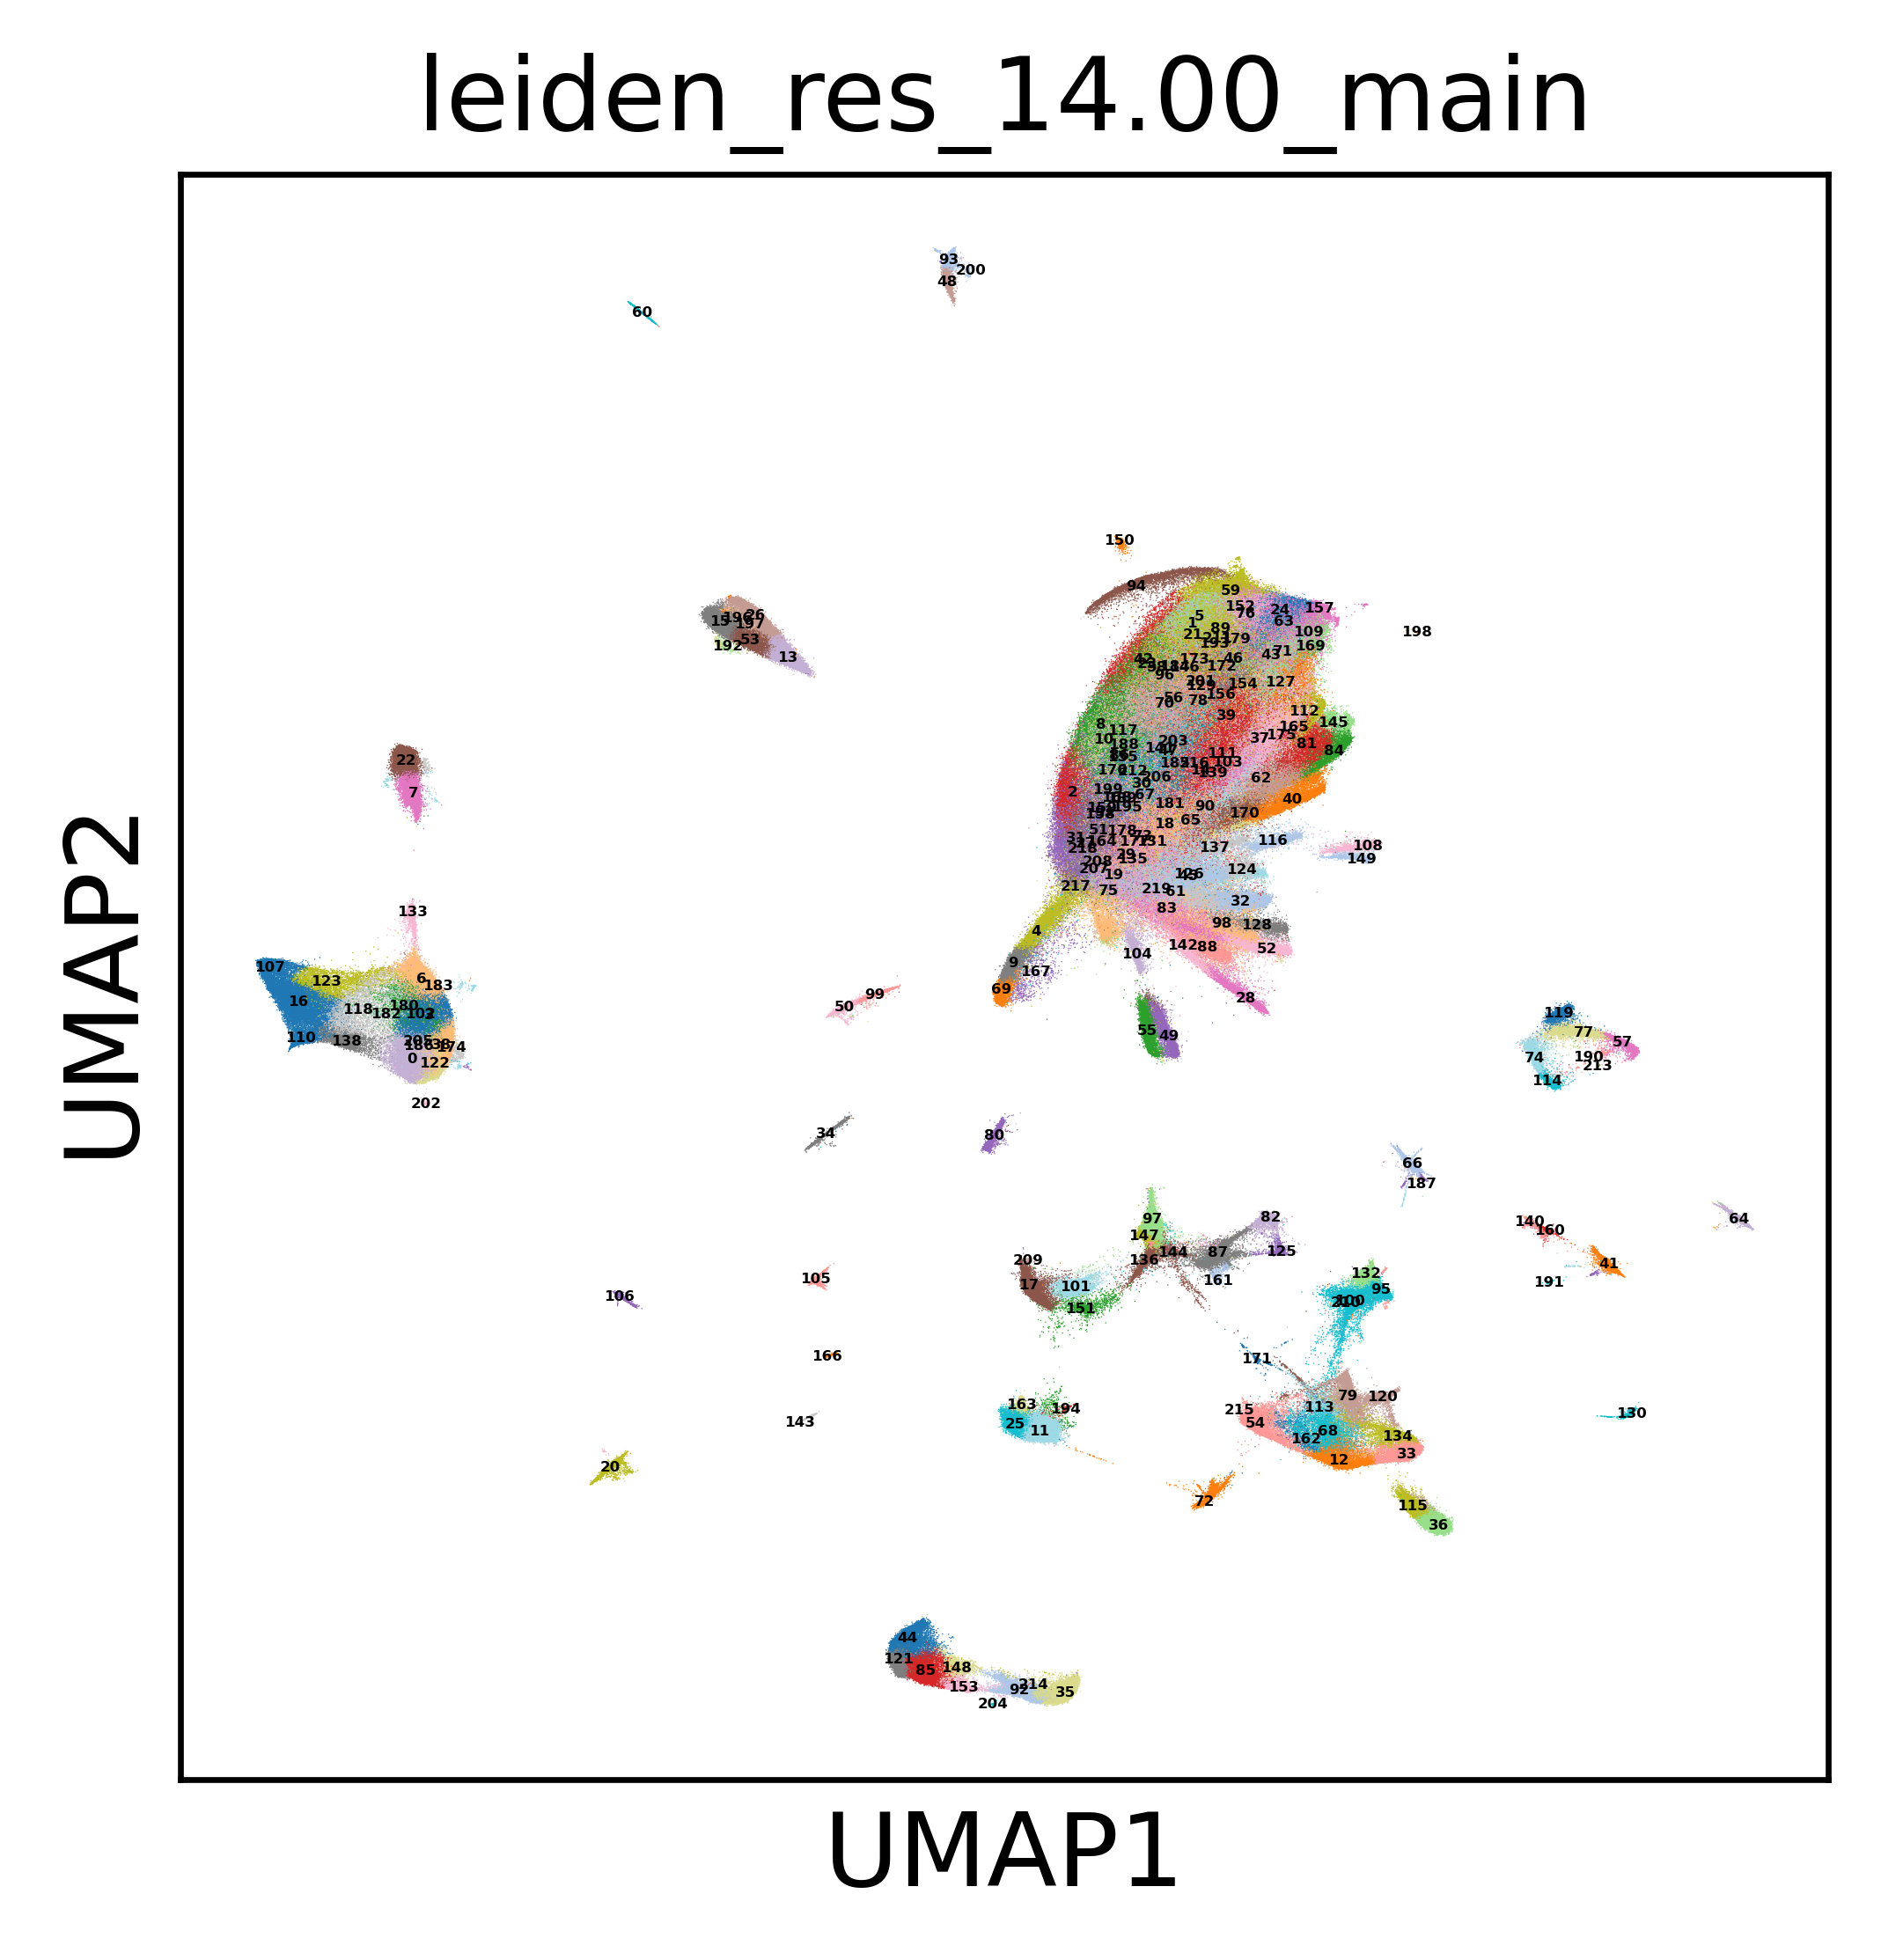

In [32]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique annotation labels
unique_annotations = adata.obs['leiden_res_14.00_main'].unique()

# Generate a large set of distinct colors
num_colors = len(unique_annotations)
palette = sns.color_palette("tab20", num_colors)  # Use "tab20", "tab20b", "tab20c", or "hsv" for more colors
color_dict = dict(zip(unique_annotations, palette))

# Assign colors to annotation categories
sc.pl.umap(adata, color='leiden_res_14.00_main', palette=color_dict, legend_loc='on data', legend_fontsize=2)


In [138]:
adata.obs['main_celltype'][adata.obs['leiden_res_0.03_main'].isin(['0', '3', '5'])] = 'Neuron'

/tmp/ipykernel_46691/2270137616.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs['main_celltype'][adata.obs['leiden_res_0.03_main'].isin(['0', '3', '5'])] = 'Neuron'
/tmp/ipykernel_46691/2270137616.py:1: SettingWithCopyWarning: 

In [139]:
adata.obs.loc[adata.obs['leiden_res_0.03_main'] == '2', 'main_celltype'] = 'Photoreceptor Neuron'

In [140]:
adata.obs.loc[adata.obs['leiden_res_0.03_main'] == '4', 'main_celltype'] = 'Fat Cells'

In [141]:
adata.obs.loc[adata.obs['leiden_res_0.03_main'] == '6', 'main_celltype'] = 'Hemocyte'

In [158]:
adata.obs['main_celltype'] = adata.obs['main_celltype'].astype(str)

In [142]:
adata.obs.loc[adata.obs['leiden_res_0.10_main'] == '6', 'main_celltype'] = 'Glia'

In [155]:
adata.obs['main_celltype'][adata.obs['leiden_res_0.60_main'].isin(['35', '38', '33'])] = 'Glia'

/tmp/ipykernel_46691/1334466447.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs['main_celltype'][adata.obs['leiden_res_0.60_main'].isin(['35', '38', '33'])] = 'Glia'
/tmp/ipykernel_46691/1334466447.py:1: SettingWithCopyWarning:

In [156]:
adata.obs['main_celltype'][adata.obs['leiden_res_0.60_main'].isin(['4', '12'])] = 'Epithelial Cells'

/tmp/ipykernel_46691/3544698869.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs['main_celltype'][adata.obs['leiden_res_0.60_main'].isin(['4', '12'])] = 'Epithelial Cells'
/tmp/ipykernel_46691/3544698869.py:1: SettingWithCopyWar

In [116]:
adata.obs['main_celltype'][adata.obs['leiden_res_0.60_main'].isin(['35', '24'])] = 'Glia'

/tmp/ipykernel_49381/1479736661.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs['main_celltype'][adata.obs['leiden_res_0.60_main'].isin(['35', '24'])] = 'Glia'
/tmp/ipykernel_49381/1479736661.py:1: SettingWithCopyWarning: 
A va

In [159]:
adata.obs.loc[adata.obs['leiden_res_0.60_main'] == '21', 'main_celltype'] = 'Muscle Cells'

In [ ]:
adata.obs.loc[adata.obs['leiden_res_2.00_main'] == '21', 'main_celltype'] = 'Glia'

In [181]:
adata.obs.loc[adata.obs['leiden_res_8.00_main'] == '65', 'main_celltype'] = 'Fat Cells'

In [177]:
# Convert categorical column to string
adata.obs['main_celltype'] = adata.obs['main_celltype'].astype(str)

# Replace NaNs with 'Unknown'
adata.obs.loc[adata.obs['main_celltype'] == 'nan', 'main_celltype'] = 'Unknown'


In [124]:
# Fix missing values
adata.obs['main_celltype'] = adata.obs['main_celltype'].fillna('Unknown')

# Standardize naming
adata.obs['main_celltype'].replace({
    'Epithelial': 'Epithelial Cells',
    'Photoreceptor': 'Photoreceptor Neuron',  # Or merge with 'Neuron'
    'Fat': 'Fat Cells',
    'Muscle': 'Muscle Cells'
}, inplace=True)


/tmp/ipykernel_49381/4247048561.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['main_celltype'].replace({


# Changing the Cell type naming conventions

In [190]:
import pandas as pd

# Dictionary mapping old acronyms to new ones
rename_dict = {
    'PRNG': 'PNG',        # Perineurial Glia
    'RNAG': 'RNPG',       # Reticular Neuropil-Associated Glia
    'oCHIG': 'OCHG',      # Ocular Chiasma Glia
    'OCTN': 'OAN',        # Octopaminergic Neurons
    'EBRN': 'EB-RN',      # Ellipsoid Body Ring Neurons
    'ALPN': 'AL-PN',      # Antennal Lobe Projection Neuron
    'lE/MG': 'LEMG',      # Lamina Epithelial/Marginal Glia
    'PEPN_1': 'PEPN',     # Peptidergic Neurons from Davie et al.
    'ASN': 'AudSN'        # Auditory Sensory Neurons
}

# Apply the renaming in the adata.obs dataframe
adata.obs['unsup_celltype'] = adata.obs['unsup_celltype'].replace(rename_dict)

# Confirm changes
print("Updated cell types:")
print(adata.obs['unsup_celltype'].unique().tolist())


Updated cell types:
[nan, 'L1', 'R1-6', 'KCab', 'DAN', 'PB', 'Tm5ab', 'T3', 'CBG', 'EPI', 'TmY4', 'CONE_2', 'FAT_1', 'KCy', 'L2', 'Tm5c', 'TmY8', 'R7', 'PNG', 'T2', 'Tm3a', 'R8', 'RNPG', 'Pm1', 'Dm3', 'Lai', 'LLPC1', 'Tm1', 'SPG', 'OCHG', 'HE', 'CLKN', 'LAWF1', 'LAWF2', 'Mi1', 'C3', 'L4', 'Mi4', 'LC16', 'T4T5ab', 'MUS', 'JON', 'Tm20', 'L3', 'KCapbp', 'OLCTG', 'CONE_1', 'L5', 'Dm9', 'TmY5a', 'ENSG', 'TmY14', 'LPLC2', 'T1', 'FAT_2', 'T2a', 'Pm2', 'SERN', 'Mi9', 'PAM-DAN', 'T4T5', 'ORN', 'Tm2', 'T4T5cd', 'OCR', 'PGM', 'Tm9', 'C2', 'OAN', 'EB-RN', 'LC12', 'Dm4', 'Mi15', 'Dm2', 'dFB', 'Dm12', 'Tm4', 'TYRN', 'Dm1', 'AL-PN', 'Tm29', 'Dm8', 'LEMG', 'LPLC1', 'LPC1', 'Dm10', 'LC4', 'LC17', 'Dm11', 'Pm4', 'LC14', 'PEPN', 'LC10', 'DRA', 'AudSN']


In [191]:
import pandas as pd

# Dictionary mapping old acronyms to new ones
rename_dict = {
    'a/b-KC': 'KCab',        # Perineurial Glia
    "a'/b'-KC": 'KCapbp',       # Reticular Neuropil-Associated Glia
    'y-KC': 'KCy',      # Ocular Chiasma Glia
    'T4/T5': 'T4T5',        # Octopaminergic Neurons
    'T4/T5a-b': 'T4T5ab',      # Ellipsoid Body Ring Neurons
    'T4/T5c-d': 'T4T5cd',      # Antennal Lobe Projection Neuron
}

# Apply the renaming in the adata.obs dataframe
adata.obs['unsup_celltype'] = adata.obs['unsup_celltype'].replace(rename_dict)

# Confirm changes
print("Updated cell types:")
print(adata.obs['unsup_celltype'].unique().tolist())


Updated cell types:
[nan, 'L1', 'R1-6', 'KCab', 'DAN', 'PB', 'Tm5ab', 'T3', 'CBG', 'EPI', 'TmY4', 'CONE_2', 'FAT_1', 'KCy', 'L2', 'Tm5c', 'TmY8', 'R7', 'PNG', 'T2', 'Tm3a', 'R8', 'RNPG', 'Pm1', 'Dm3', 'Lai', 'LLPC1', 'Tm1', 'SPG', 'OCHG', 'HE', 'CLKN', 'LAWF1', 'LAWF2', 'Mi1', 'C3', 'L4', 'Mi4', 'LC16', 'T4T5ab', 'MUS', 'JON', 'Tm20', 'L3', 'KCapbp', 'OLCTG', 'CONE_1', 'L5', 'Dm9', 'TmY5a', 'ENSG', 'TmY14', 'LPLC2', 'T1', 'FAT_2', 'T2a', 'Pm2', 'SERN', 'Mi9', 'PAM-DAN', 'T4T5', 'ORN', 'Tm2', 'T4T5cd', 'OCR', 'PGM', 'Tm9', 'C2', 'OAN', 'EB-RN', 'LC12', 'Dm4', 'Mi15', 'Dm2', 'dFB', 'Dm12', 'Tm4', 'TYRN', 'Dm1', 'AL-PN', 'Tm29', 'Dm8', 'LEMG', 'LPLC1', 'LPC1', 'Dm10', 'LC4', 'LC17', 'Dm11', 'Pm4', 'LC14', 'PEPN', 'LC10', 'DRA', 'AudSN']


In [192]:
import pandas as pd

# Dictionary mapping old acronyms to new ones, including capitalization updates
rename_dict = {
    'PRNG': 'PNG',        # Perineurial Glia
    'RNAG': 'RNPG',       # Reticular Neuropil-Associated Glia
    'oCHIG': 'OCHG',      # Ocular Chiasma Glia
    'OCTN': 'OAN',        # Octopaminergic Neurons
    'EBRN': 'EB-RN',      # Ellipsoid Body Ring Neurons
    'ALPN': 'AL-PN',      # Antennal Lobe Projection Neuron
    'lE/MG': 'LEMG',      # Lamina Epithelial/Marginal Glia
    'PEPN_1': 'PEPN',     # Peptidergic Neurons from Davie et al.
    'ASN': 'AudSN',       # Auditory Sensory Neurons
    'lawf1': 'LAWF1',     # Lamina Wide-Field Neuron 1 (capitalized for consistency)
    'lawf2': 'LAWF2'      # Lamina Wide-Field Neuron 2 (capitalized for consistency)
}

# Apply the renaming in the adata.obs dataframe
adata.obs['unsup_celltype'] = adata.obs['unsup_celltype'].replace(rename_dict)

# Confirm changes
print("Updated cell types:")
print(adata.obs['unsup_celltype'].unique().tolist())


Updated cell types:
[nan, 'L1', 'R1-6', 'KCab', 'DAN', 'PB', 'Tm5ab', 'T3', 'CBG', 'EPI', 'TmY4', 'CONE_2', 'FAT_1', 'KCy', 'L2', 'Tm5c', 'TmY8', 'R7', 'PNG', 'T2', 'Tm3a', 'R8', 'RNPG', 'Pm1', 'Dm3', 'Lai', 'LLPC1', 'Tm1', 'SPG', 'OCHG', 'HE', 'CLKN', 'LAWF1', 'LAWF2', 'Mi1', 'C3', 'L4', 'Mi4', 'LC16', 'T4T5ab', 'MUS', 'JON', 'Tm20', 'L3', 'KCapbp', 'OLCTG', 'CONE_1', 'L5', 'Dm9', 'TmY5a', 'ENSG', 'TmY14', 'LPLC2', 'T1', 'FAT_2', 'T2a', 'Pm2', 'SERN', 'Mi9', 'PAM-DAN', 'T4T5', 'ORN', 'Tm2', 'T4T5cd', 'OCR', 'PGM', 'Tm9', 'C2', 'OAN', 'EB-RN', 'LC12', 'Dm4', 'Mi15', 'Dm2', 'dFB', 'Dm12', 'Tm4', 'TYRN', 'Dm1', 'AL-PN', 'Tm29', 'Dm8', 'LEMG', 'LPLC1', 'LPC1', 'Dm10', 'LC4', 'LC17', 'Dm11', 'Pm4', 'LC14', 'PEPN', 'LC10', 'DRA', 'AudSN']


In [193]:
import pandas as pd

# Dictionary mapping old acronyms to new ones, including olCTXG → OLCTG
rename_dict = {
    'PRNG': 'PNG',        # Perineurial Glia
    'RNAG': 'RNPG',       # Reticular Neuropil-Associated Glia
    'oCHIG': 'OCHG',      # Ocular Chiasma Glia
    'OCTN': 'OAN',        # Octopaminergic Neurons
    'EBRN': 'EB-RN',      # Ellipsoid Body Ring Neurons
    'ALPN': 'AL-PN',      # Antennal Lobe Projection Neuron
    'lE/MG': 'LEMG',      # Lamina Epithelial/Marginal Glia
    'PEPN_1': 'PEPN',     # Peptidergic Neurons from Davie et al.
    'ASN': 'AudSN',       # Auditory Sensory Neurons
    'lawf1': 'LAWF1',     # Lamina Wide-Field Neuron 1 (capitalized for consistency)
    'lawf2': 'LAWF2',     # Lamina Wide-Field Neuron 2 (capitalized for consistency)
    'olCTXG': 'OLCTG'     # Optic Lobe Cortex Glia (renamed for consistency)
}

# Apply the renaming in the adata.obs dataframe
adata.obs['unsup_celltype'] = adata.obs['unsup_celltype'].replace(rename_dict)

# Confirm changes
print("Updated cell types:")
print(adata.obs['unsup_celltype'].unique().tolist())


Updated cell types:
[nan, 'L1', 'R1-6', 'KCab', 'DAN', 'PB', 'Tm5ab', 'T3', 'CBG', 'EPI', 'TmY4', 'CONE_2', 'FAT_1', 'KCy', 'L2', 'Tm5c', 'TmY8', 'R7', 'PNG', 'T2', 'Tm3a', 'R8', 'RNPG', 'Pm1', 'Dm3', 'Lai', 'LLPC1', 'Tm1', 'SPG', 'OCHG', 'HE', 'CLKN', 'LAWF1', 'LAWF2', 'Mi1', 'C3', 'L4', 'Mi4', 'LC16', 'T4T5ab', 'MUS', 'JON', 'Tm20', 'L3', 'KCapbp', 'OLCTG', 'CONE_1', 'L5', 'Dm9', 'TmY5a', 'ENSG', 'TmY14', 'LPLC2', 'T1', 'FAT_2', 'T2a', 'Pm2', 'SERN', 'Mi9', 'PAM-DAN', 'T4T5', 'ORN', 'Tm2', 'T4T5cd', 'OCR', 'PGM', 'Tm9', 'C2', 'OAN', 'EB-RN', 'LC12', 'Dm4', 'Mi15', 'Dm2', 'dFB', 'Dm12', 'Tm4', 'TYRN', 'Dm1', 'AL-PN', 'Tm29', 'Dm8', 'LEMG', 'LPLC1', 'LPC1', 'Dm10', 'LC4', 'LC17', 'Dm11', 'Pm4', 'LC14', 'PEPN', 'LC10', 'DRA', 'AudSN']


# Annotating everything but the neurons

/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


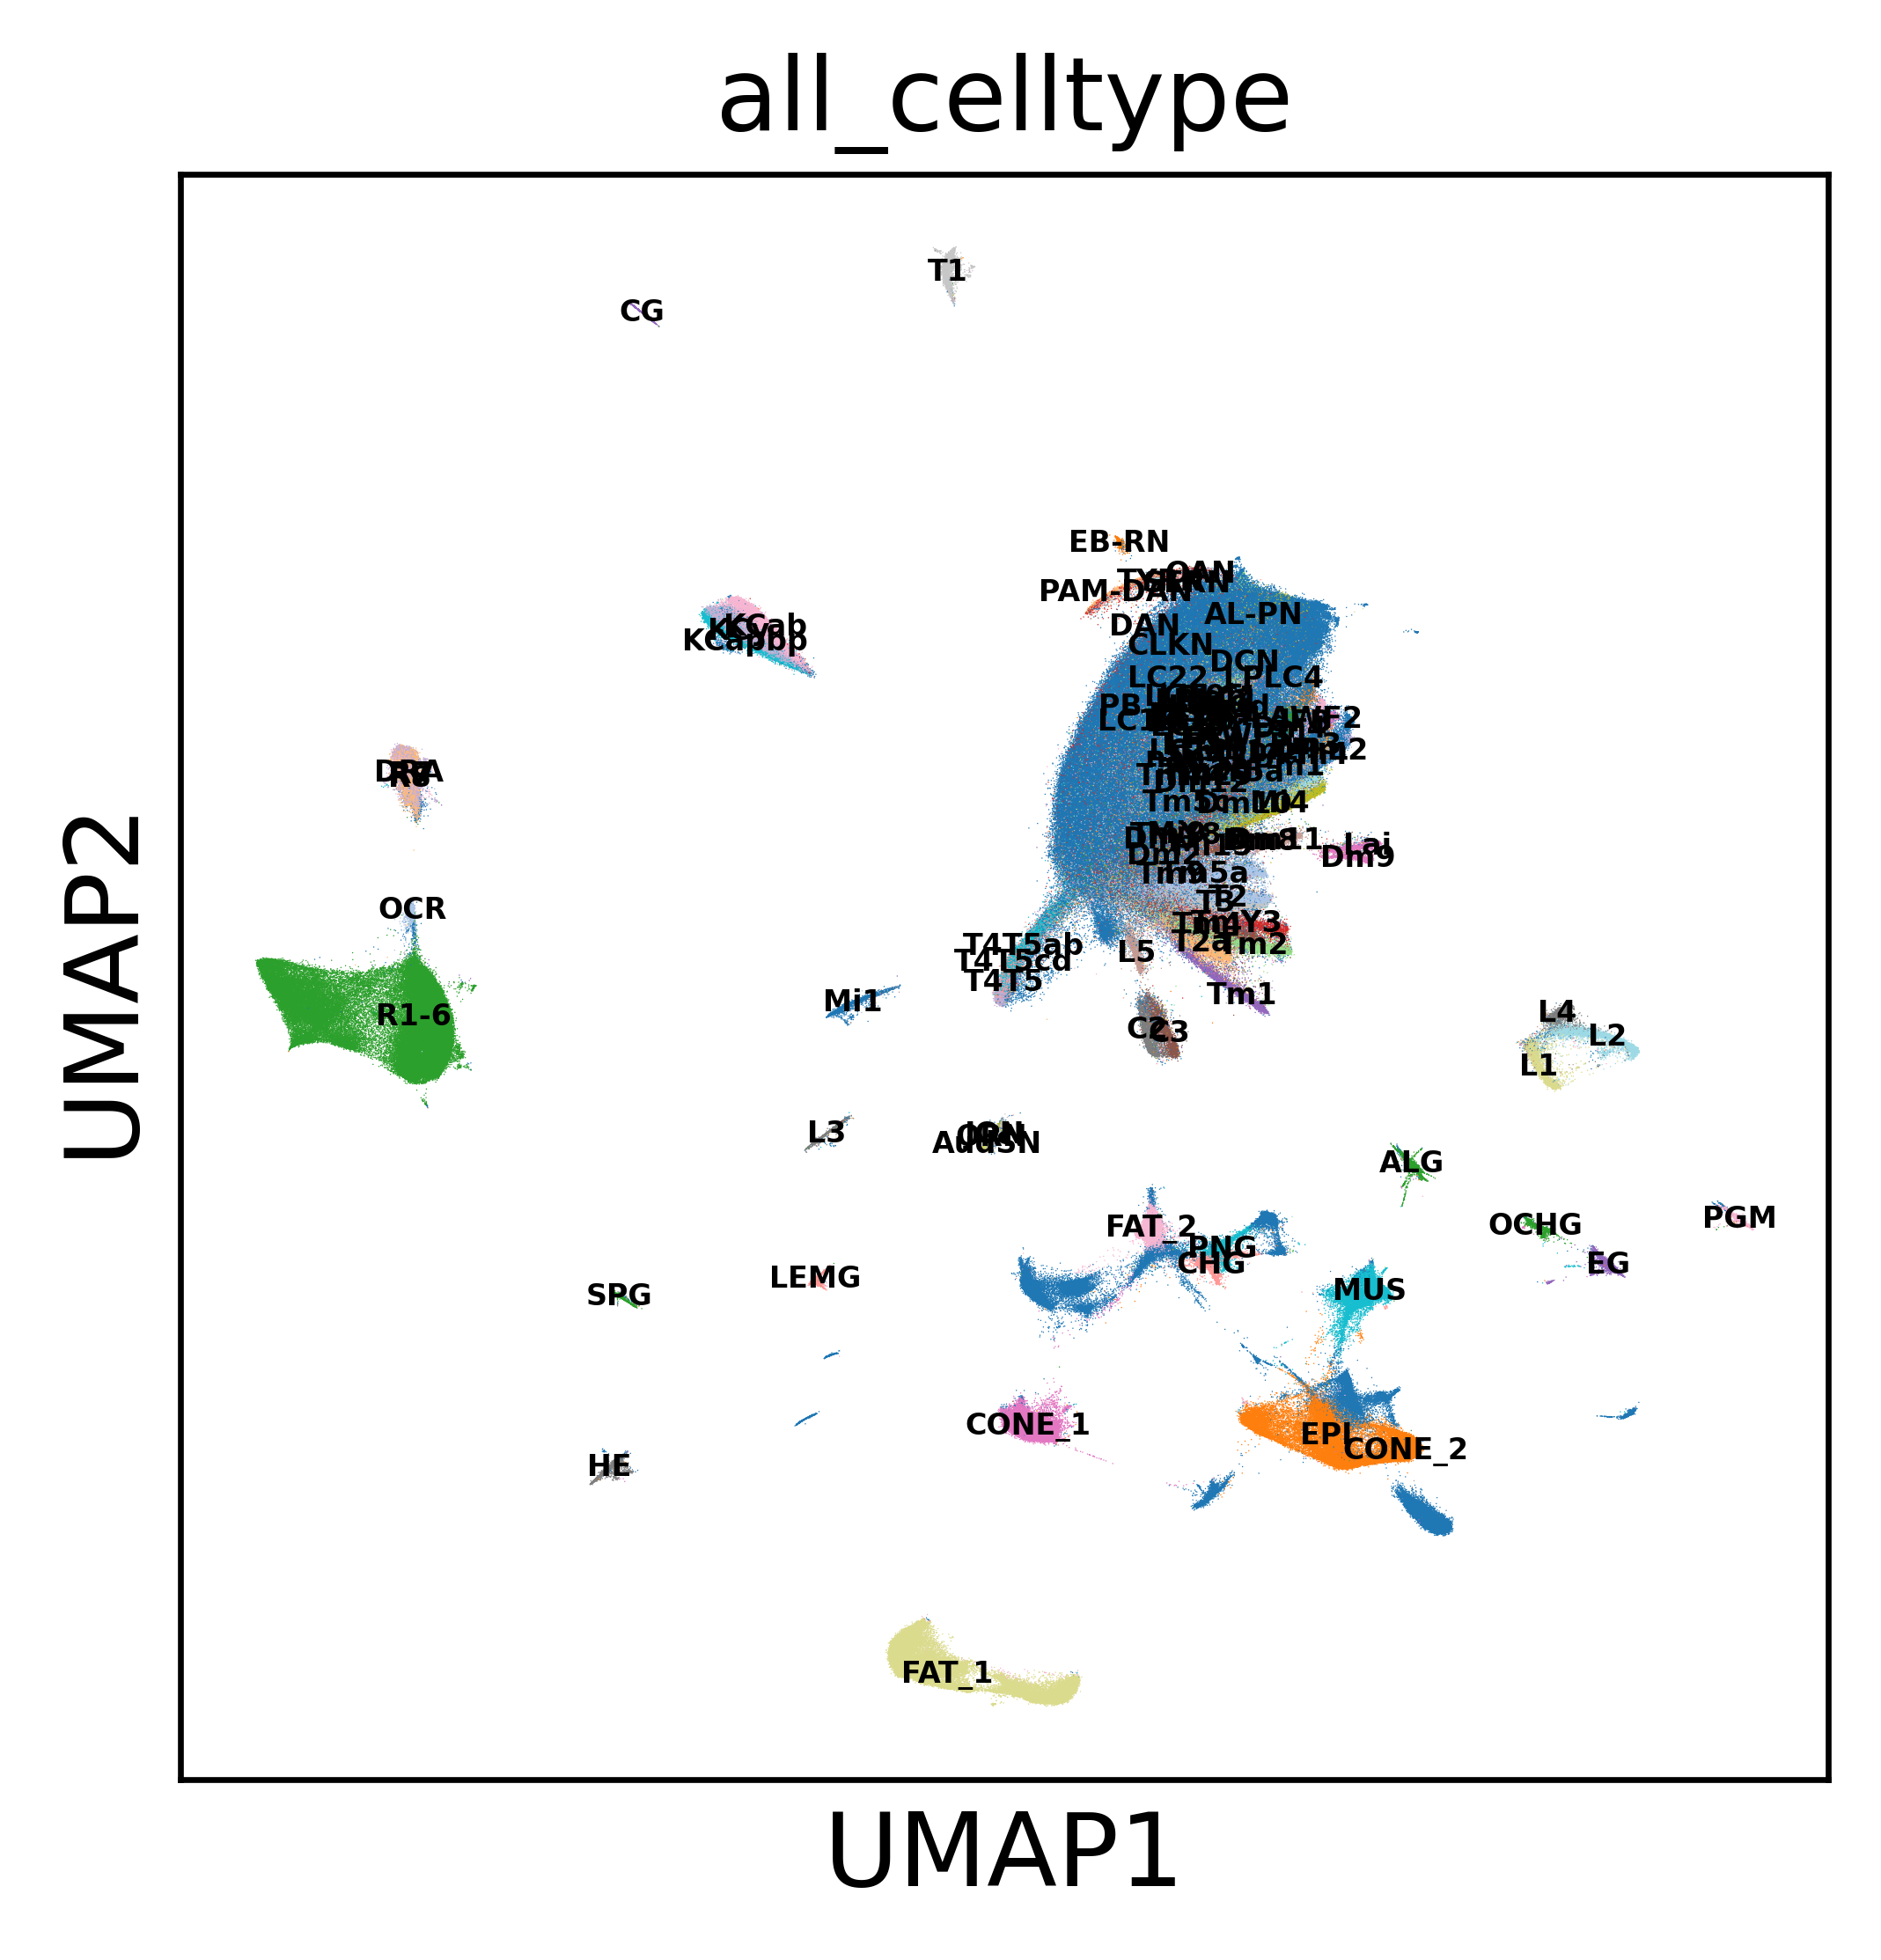

In [61]:
sc.pl.umap(adata, color = 'all_celltype', legend_loc = 'on data', legend_fontsize=4)

In [15]:
adata.obs['all_celltype'] = adata.obs['all_celltype'].astype(str)
adata.obs.loc[adata.obs['all_celltype'] == 'CBG', 'all_celltype'] = 'CG'
adata.obs['celltype_without_neurons'] = adata.obs['celltype_without_neurons'].astype(str)
adata.obs.loc[adata.obs['celltype_without_neurons'] == 'CBG', 'celltype_without_neurons'] = 'CG'

In [18]:
adata.obs['all_celltype'] = adata.obs['all_celltype'].astype(str)
adata.obs.loc[adata.obs['all_celltype'] == 'RNPG', 'all_celltype'] = 'ALG'
adata.obs['celltype_without_neurons'] = adata.obs['celltype_without_neurons'].astype(str)
adata.obs.loc[adata.obs['celltype_without_neurons'] == 'RNPG', 'celltype_without_neurons'] = 'ALG'

In [21]:
adata.obs['all_celltype'] = adata.obs['all_celltype'].astype(str)
adata.obs.loc[adata.obs['all_celltype'] == 'ENSG', 'all_celltype'] = 'EG'
adata.obs['celltype_without_neurons'] = adata.obs['celltype_without_neurons'].astype(str)
adata.obs.loc[adata.obs['celltype_without_neurons'] == 'ENSG', 'celltype_without_neurons'] = 'EG'

In [25]:
import numpy as np
adata.obs['all_celltype'] = adata.obs['all_celltype'].astype(str)
adata.obs.loc[adata.obs['all_celltype'] == 'SPG', 'all_celltype'] = np.nan
adata.obs['celltype_without_neurons'] = adata.obs['celltype_without_neurons'].astype(str)
adata.obs.loc[adata.obs['celltype_without_neurons'] == 'SPG', 'celltype_without_neurons'] = np.nan

In [28]:
import numpy as np
adata.obs['all_celltype'] = adata.obs['all_celltype'].astype(str)
adata.obs.loc[adata.obs['all_celltype'] == 'OLCTG', 'all_celltype'] = 'SPG'
adata.obs['celltype_without_neurons'] = adata.obs['celltype_without_neurons'].astype(str)
adata.obs.loc[adata.obs['celltype_without_neurons'] == 'OLCTG', 'celltype_without_neurons'] = 'SPG'

In [32]:
import numpy as np
adata.obs['all_celltype'] = adata.obs['all_celltype'].astype(str)
adata.obs.loc[adata.obs['all_celltype'] == 'PNG', 'all_celltype'] = np.nan
adata.obs['celltype_without_neurons'] = adata.obs['celltype_without_neurons'].astype(str)
adata.obs.loc[adata.obs['celltype_without_neurons'] == 'PNG', 'celltype_without_neurons'] = np.nan

In [42]:
adata.obs['celltype_without_neurons'] = adata.obs['celltype_without_neurons'].astype(str)
adata.obs.loc[adata.obs['celltype_without_neurons'] == 'nan', 'celltype_without_neurons'] = 'Unknown'

/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


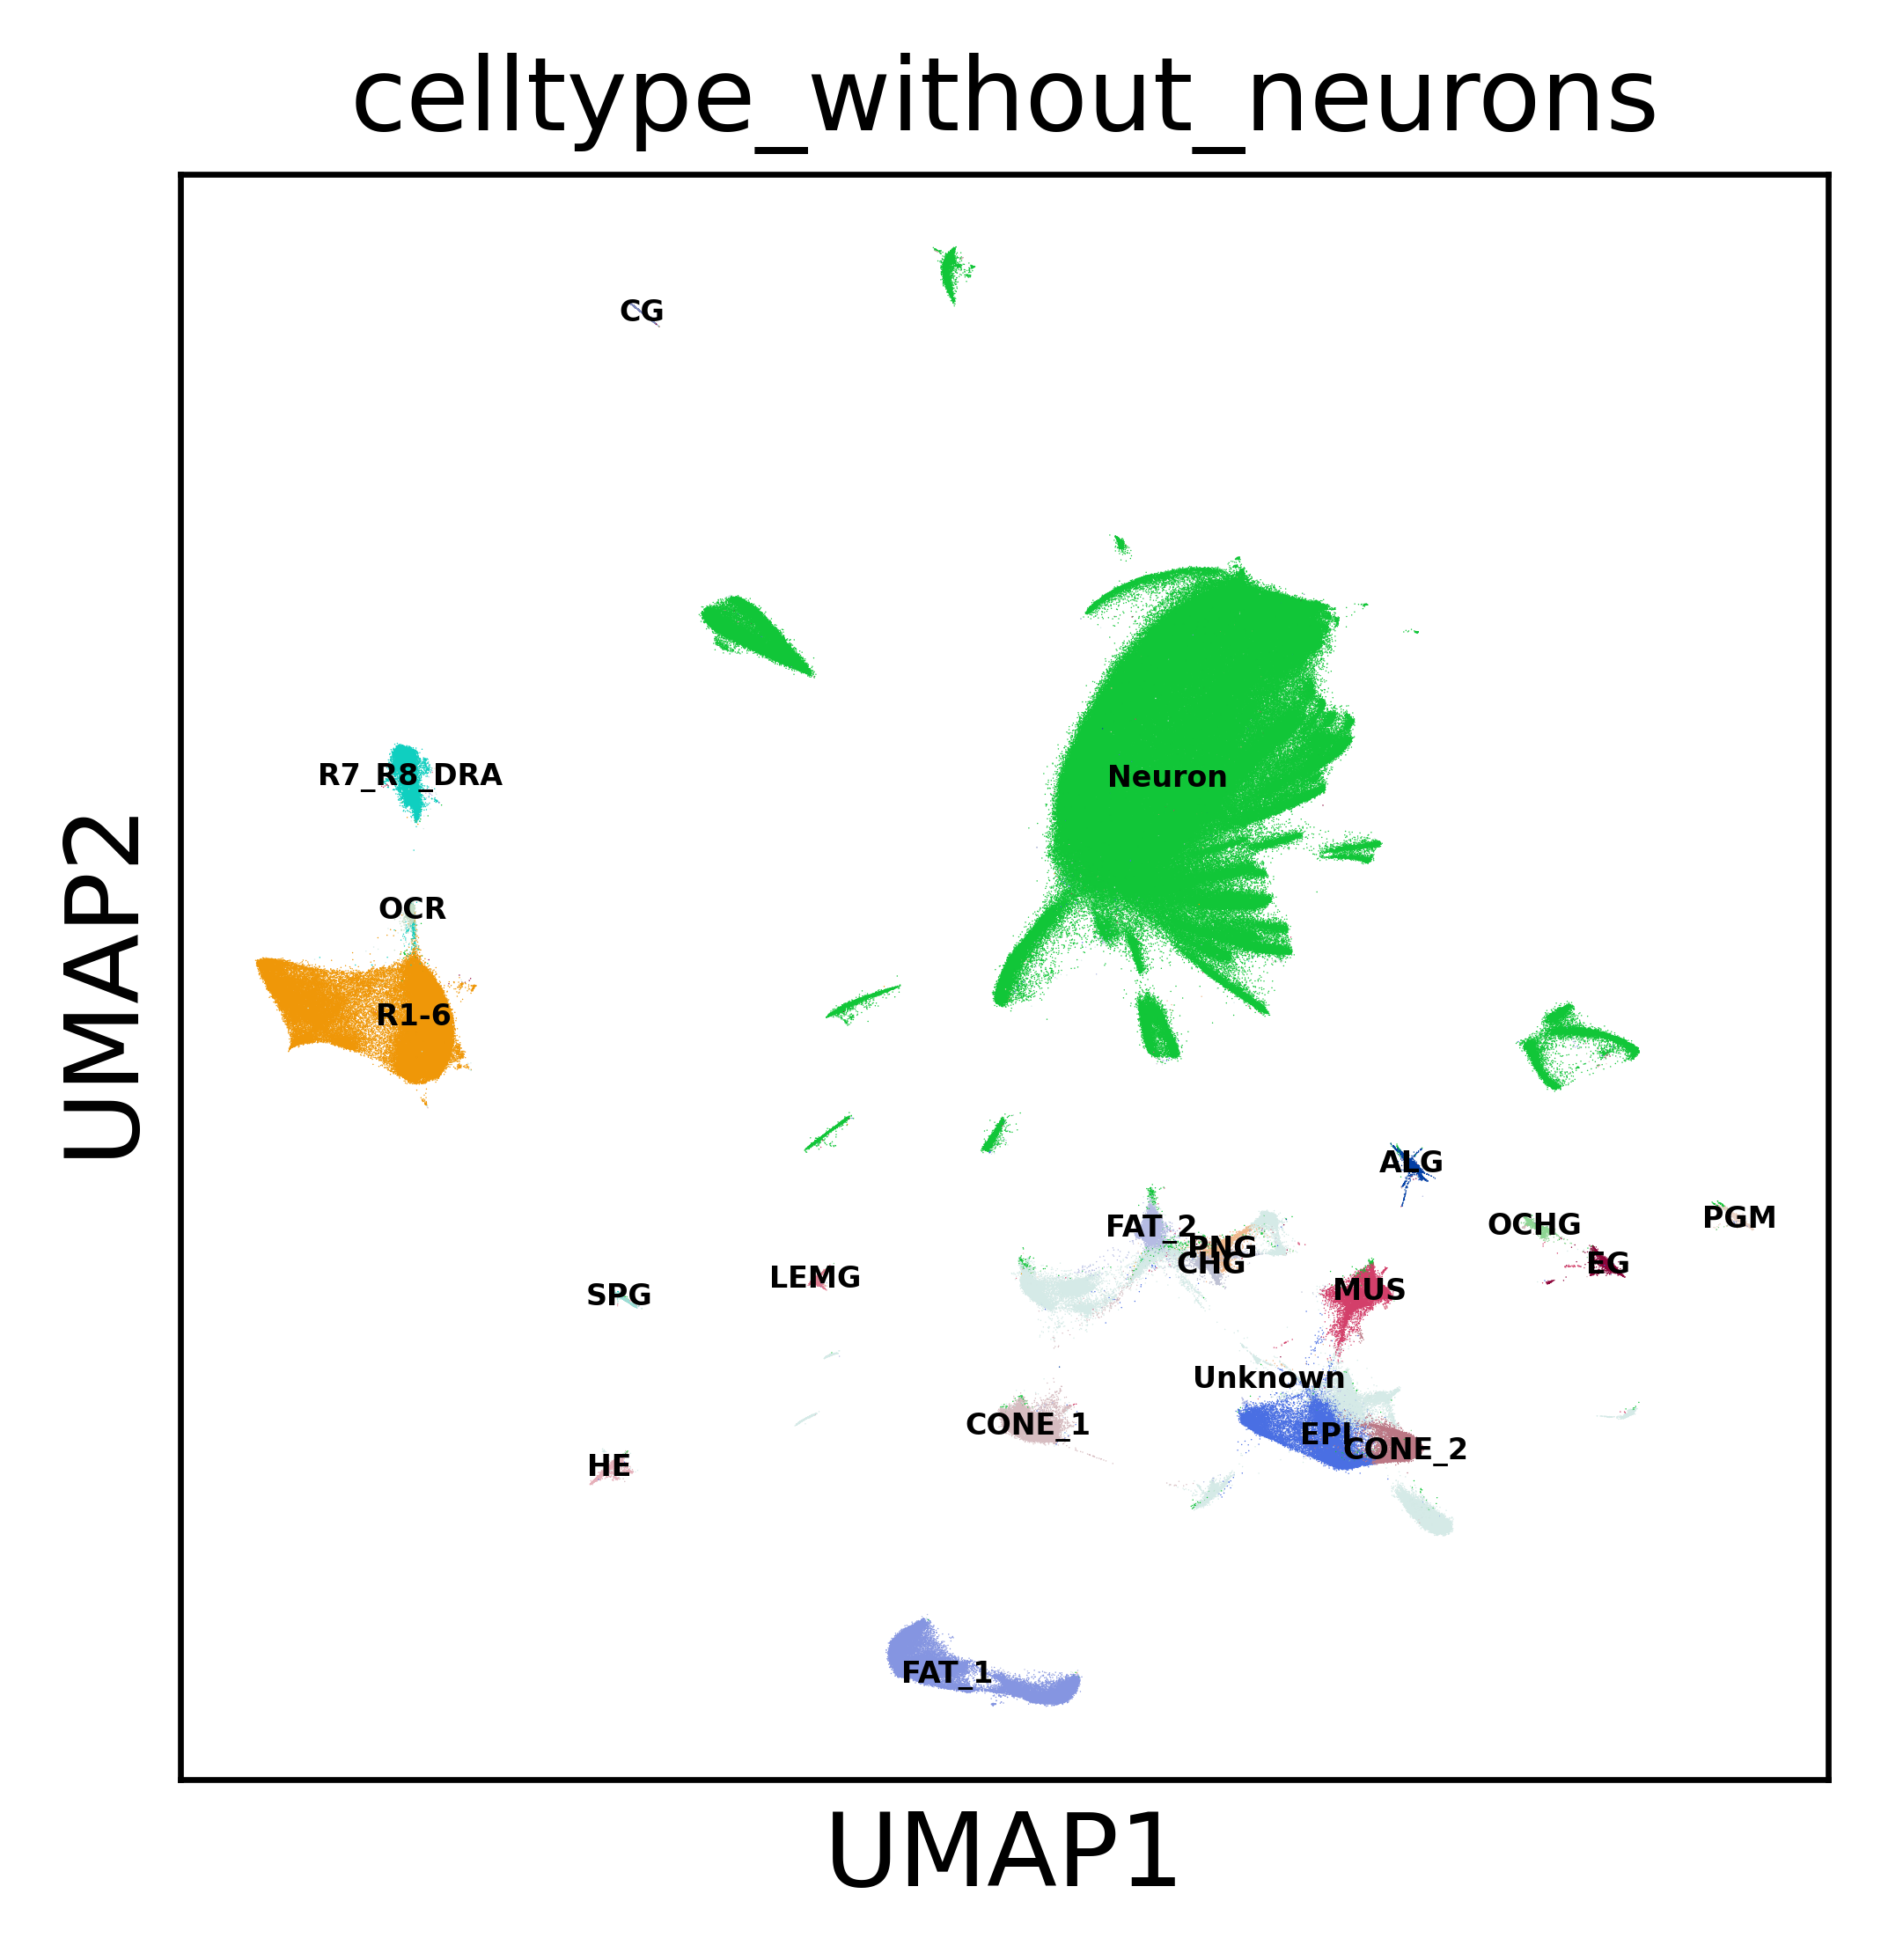

In [60]:
sc.pl.umap(adata, color = 'celltype_without_neurons', legend_loc = 'on data', legend_fontsize=4)

In [49]:
adata.obs['all_celltype'] = adata.obs['all_celltype'].astype(str)
adata.obs.loc[adata.obs['leiden_res_16.00_main'] == '150', 'all_celltype'] = 'CHG'
adata.obs['celltype_without_neurons'] = adata.obs['celltype_without_neurons'].astype(str)
adata.obs.loc[adata.obs['leiden_res_16.00_main'] == '150', 'celltype_without_neurons'] = 'CHG'
adata.obs['all_celltype'] = adata.obs['all_celltype'].astype(str)
adata.obs.loc[adata.obs['leiden_res_16.00_main'] == '179', 'all_celltype'] = 'CHG'
adata.obs['celltype_without_neurons'] = adata.obs['celltype_without_neurons'].astype(str)
adata.obs.loc[adata.obs['leiden_res_16.00_main'] == '179', 'celltype_without_neurons'] = 'CHG'

In [52]:
adata.obs['all_celltype'] = adata.obs['all_celltype'].astype(str)
adata.obs.loc[adata.obs['leiden_res_16.00_main'] == '123', 'all_celltype'] = 'PNG'
adata.obs['celltype_without_neurons'] = adata.obs['celltype_without_neurons'].astype(str)
adata.obs.loc[adata.obs['leiden_res_16.00_main'] == '123', 'celltype_without_neurons'] = 'PNG'

In [200]:
adata.obs.loc[adata.obs['leiden_res_0.03_main'] == '6', 'celltype_without_neurons'] = 'HE'

In [201]:
adata.obs.loc[adata.obs['leiden_res_0.03_main'] == '4', 'celltype_without_neurons'] = 'FAT_1'

In [202]:
adata.obs.loc[adata.obs['leiden_res_0.03_main'] == '7', 'celltype_without_neurons'] = 'CBG'

In [208]:
adata.obs.loc[adata.obs['leiden_res_0.10_main'] == '12', 'celltype_without_neurons'] = 'SPG'

In [213]:
adata.obs.loc[adata.obs['leiden_res_0.60_main'] == '3', 'celltype_without_neurons'] = 'R1-6'

In [214]:
adata.obs.loc[adata.obs['leiden_res_0.60_main'] == '10', 'celltype_without_neurons'] = 'R1-6'

In [215]:
adata.obs.loc[adata.obs['leiden_res_0.60_main'] == '35', 'celltype_without_neurons'] = 'OLCTG'

In [227]:
adata.obs.loc[adata.obs['leiden_res_0.60_main'] == '12', 'celltype_without_neurons'] = 'CONE_1'

In [231]:
adata.obs.loc[adata.obs['leiden_res_0.60_main'] == '21', 'celltype_without_neurons'] = 'MUS'

In [234]:
adata.obs.loc[adata.obs['leiden_res_0.60_main'] == '33', 'celltype_without_neurons'] = 'PGM'

In [236]:
adata.obs.loc[adata.obs['leiden_res_0.60_main'] == '26', 'celltype_without_neurons'] = 'ENSG'

In [235]:
adata.obs.loc[adata.obs['leiden_res_0.60_main'] == '31', 'celltype_without_neurons'] = 'RNPG'

In [241]:
adata.obs.loc[adata.obs['leiden_res_2.00_main'] == '31', 'celltype_without_neurons'] = 'PNG'

In [260]:
adata.obs.loc[adata.obs['leiden_res_2.00_main'] == '47', 'celltype_without_neurons'] = 'OCHG'

In [261]:
adata.obs.loc[adata.obs['leiden_res_2.00_main'] == '51', 'celltype_without_neurons'] = 'OCR'

In [265]:
adata.obs.loc[adata.obs['leiden_res_2.00_main'] == '44', 'celltype_without_neurons'] = 'LEMG'

In [268]:
adata.obs.loc[adata.obs['leiden_res_2.00_main'] == '14', 'celltype_without_neurons'] = 'R7, R8, DRA'

In [253]:
adata.obs.loc[adata.obs['leiden_res_4.00_main'] == '14', 'celltype_without_neurons'] = 'EPI'

In [254]:
adata.obs.loc[adata.obs['leiden_res_4.00_main'] == '47', 'celltype_without_neurons'] = 'EPI'

In [255]:
adata.obs.loc[adata.obs['leiden_res_4.00_main'] == '33', 'celltype_without_neurons'] = 'CONE_2'

In [275]:
adata.obs.loc[adata.obs['leiden_res_8.00_main'] == '65', 'celltype_without_neurons'] = 'FAT_2'

/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


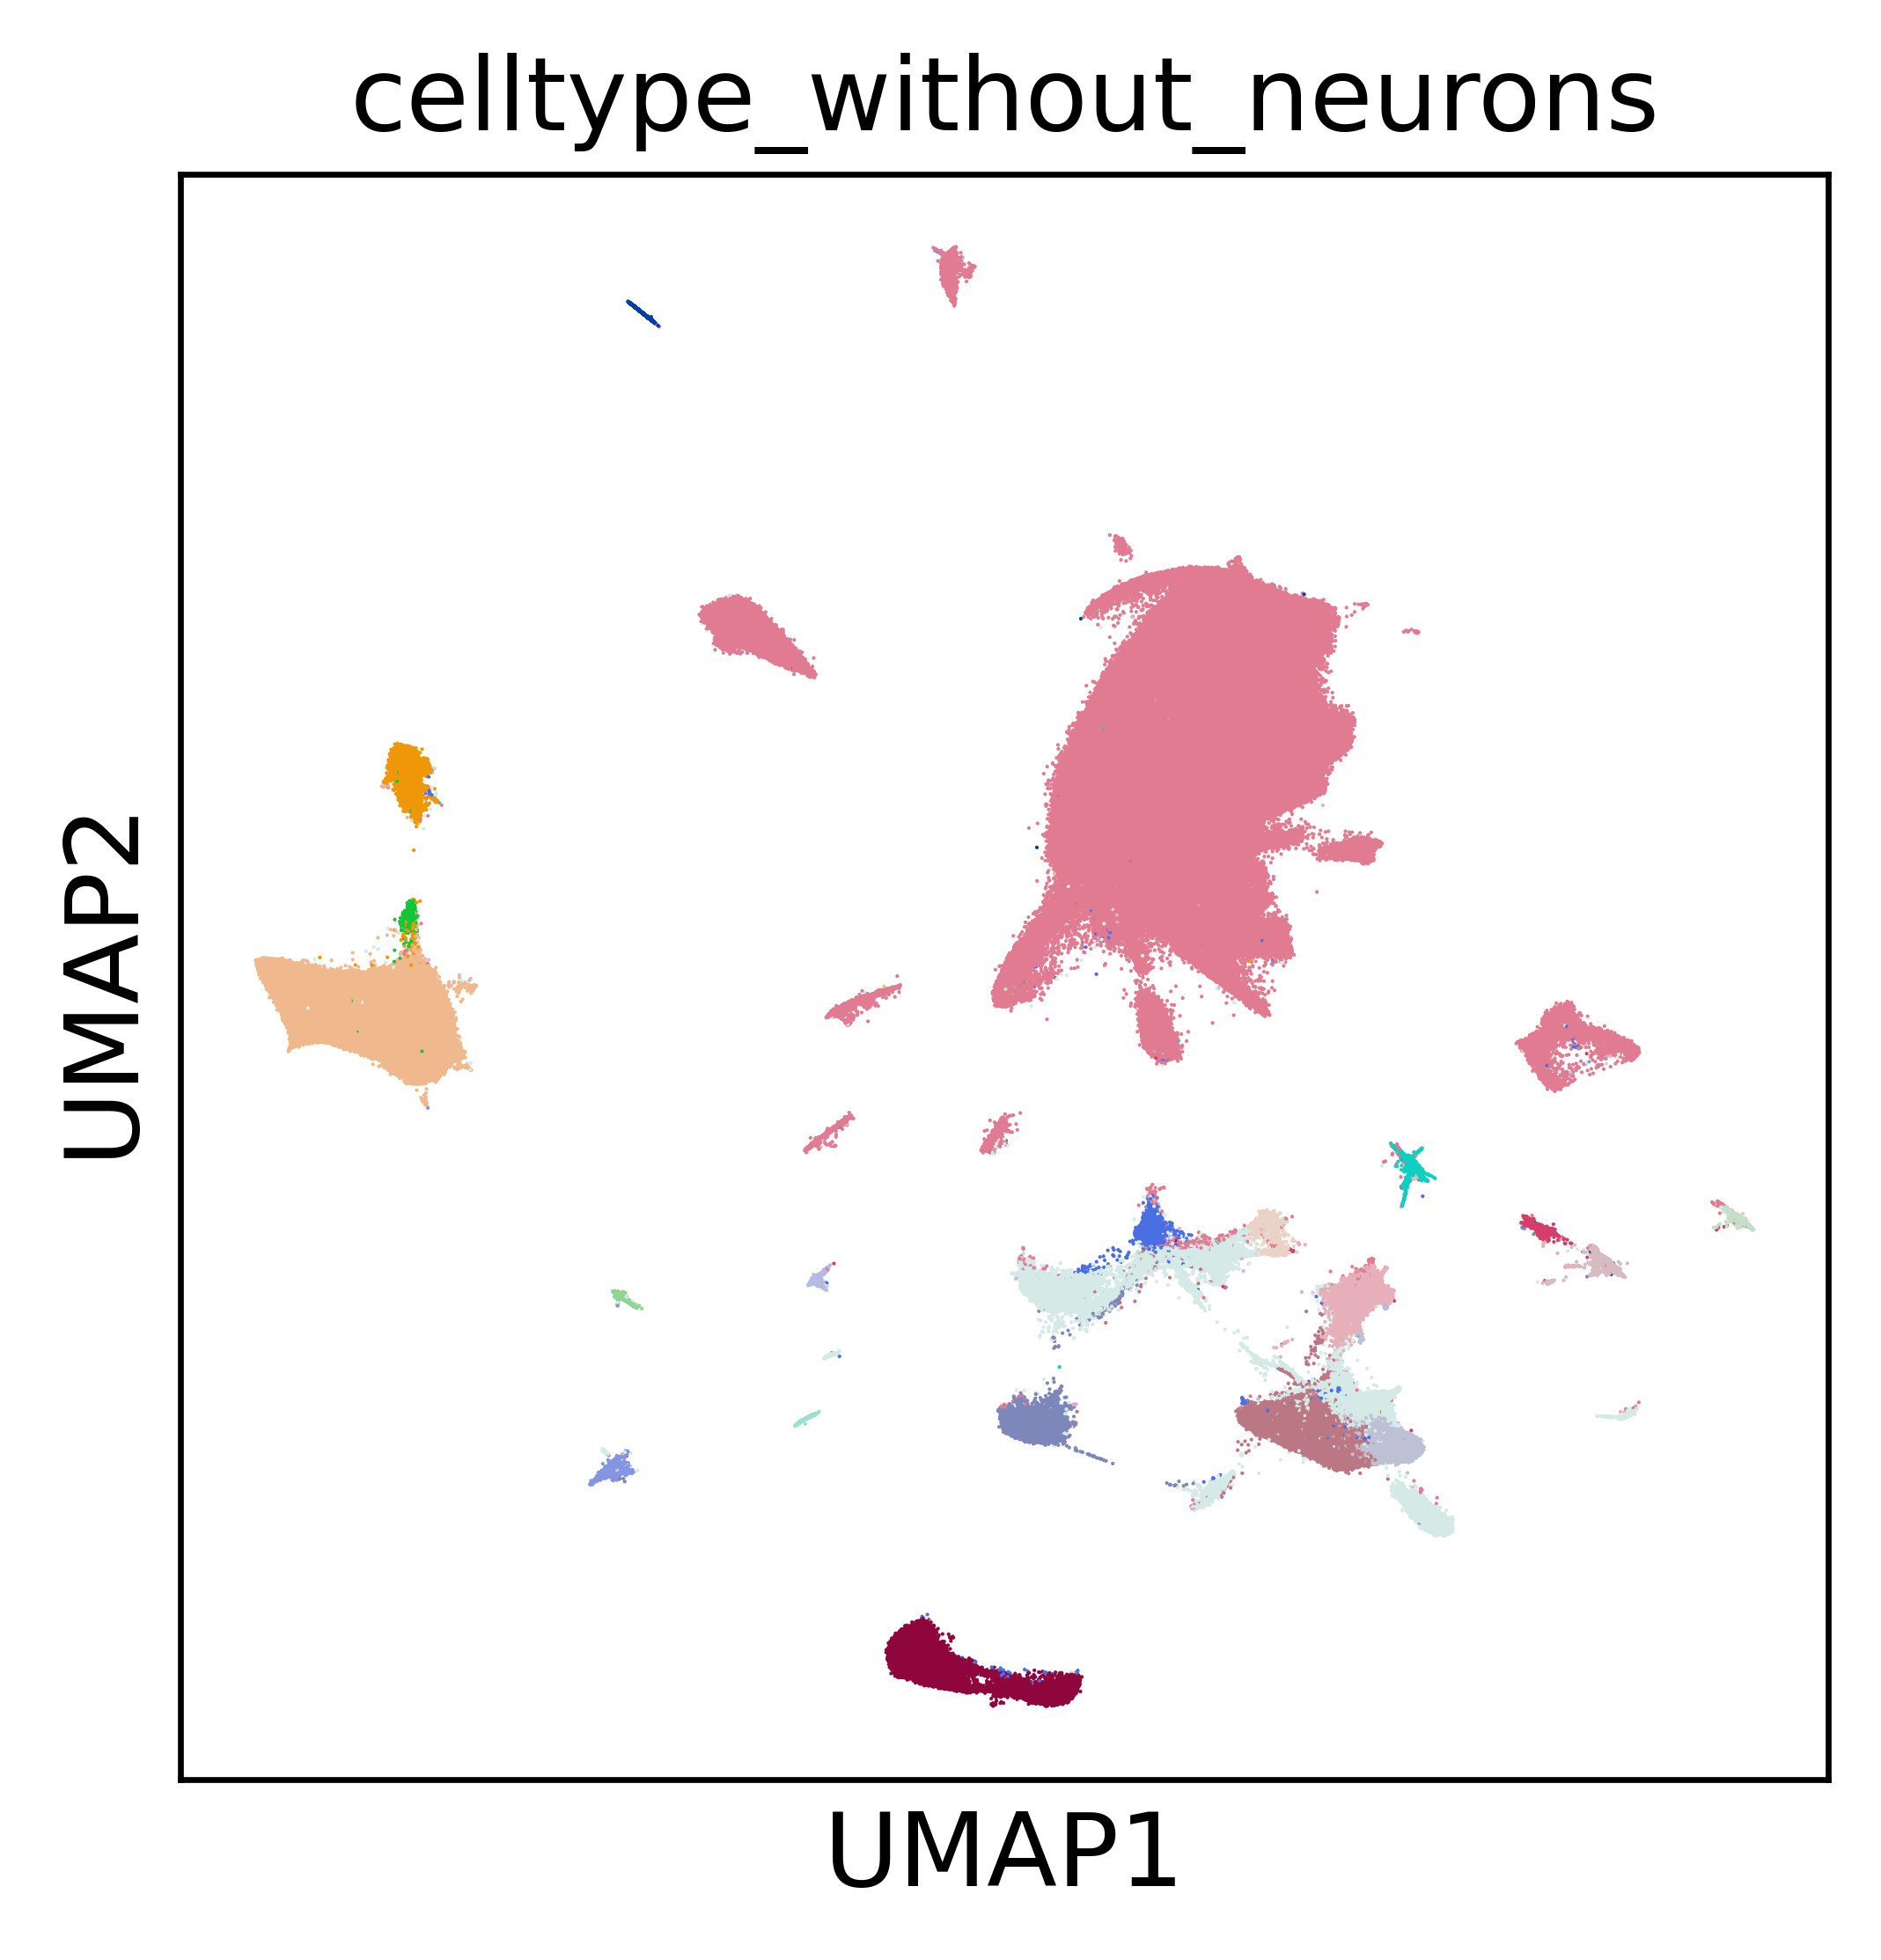

In [8]:
sc.pl.umap(adata, color = 'celltype_without_neurons', legend_loc = None, legend_fontsize=4, size = 1)

/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


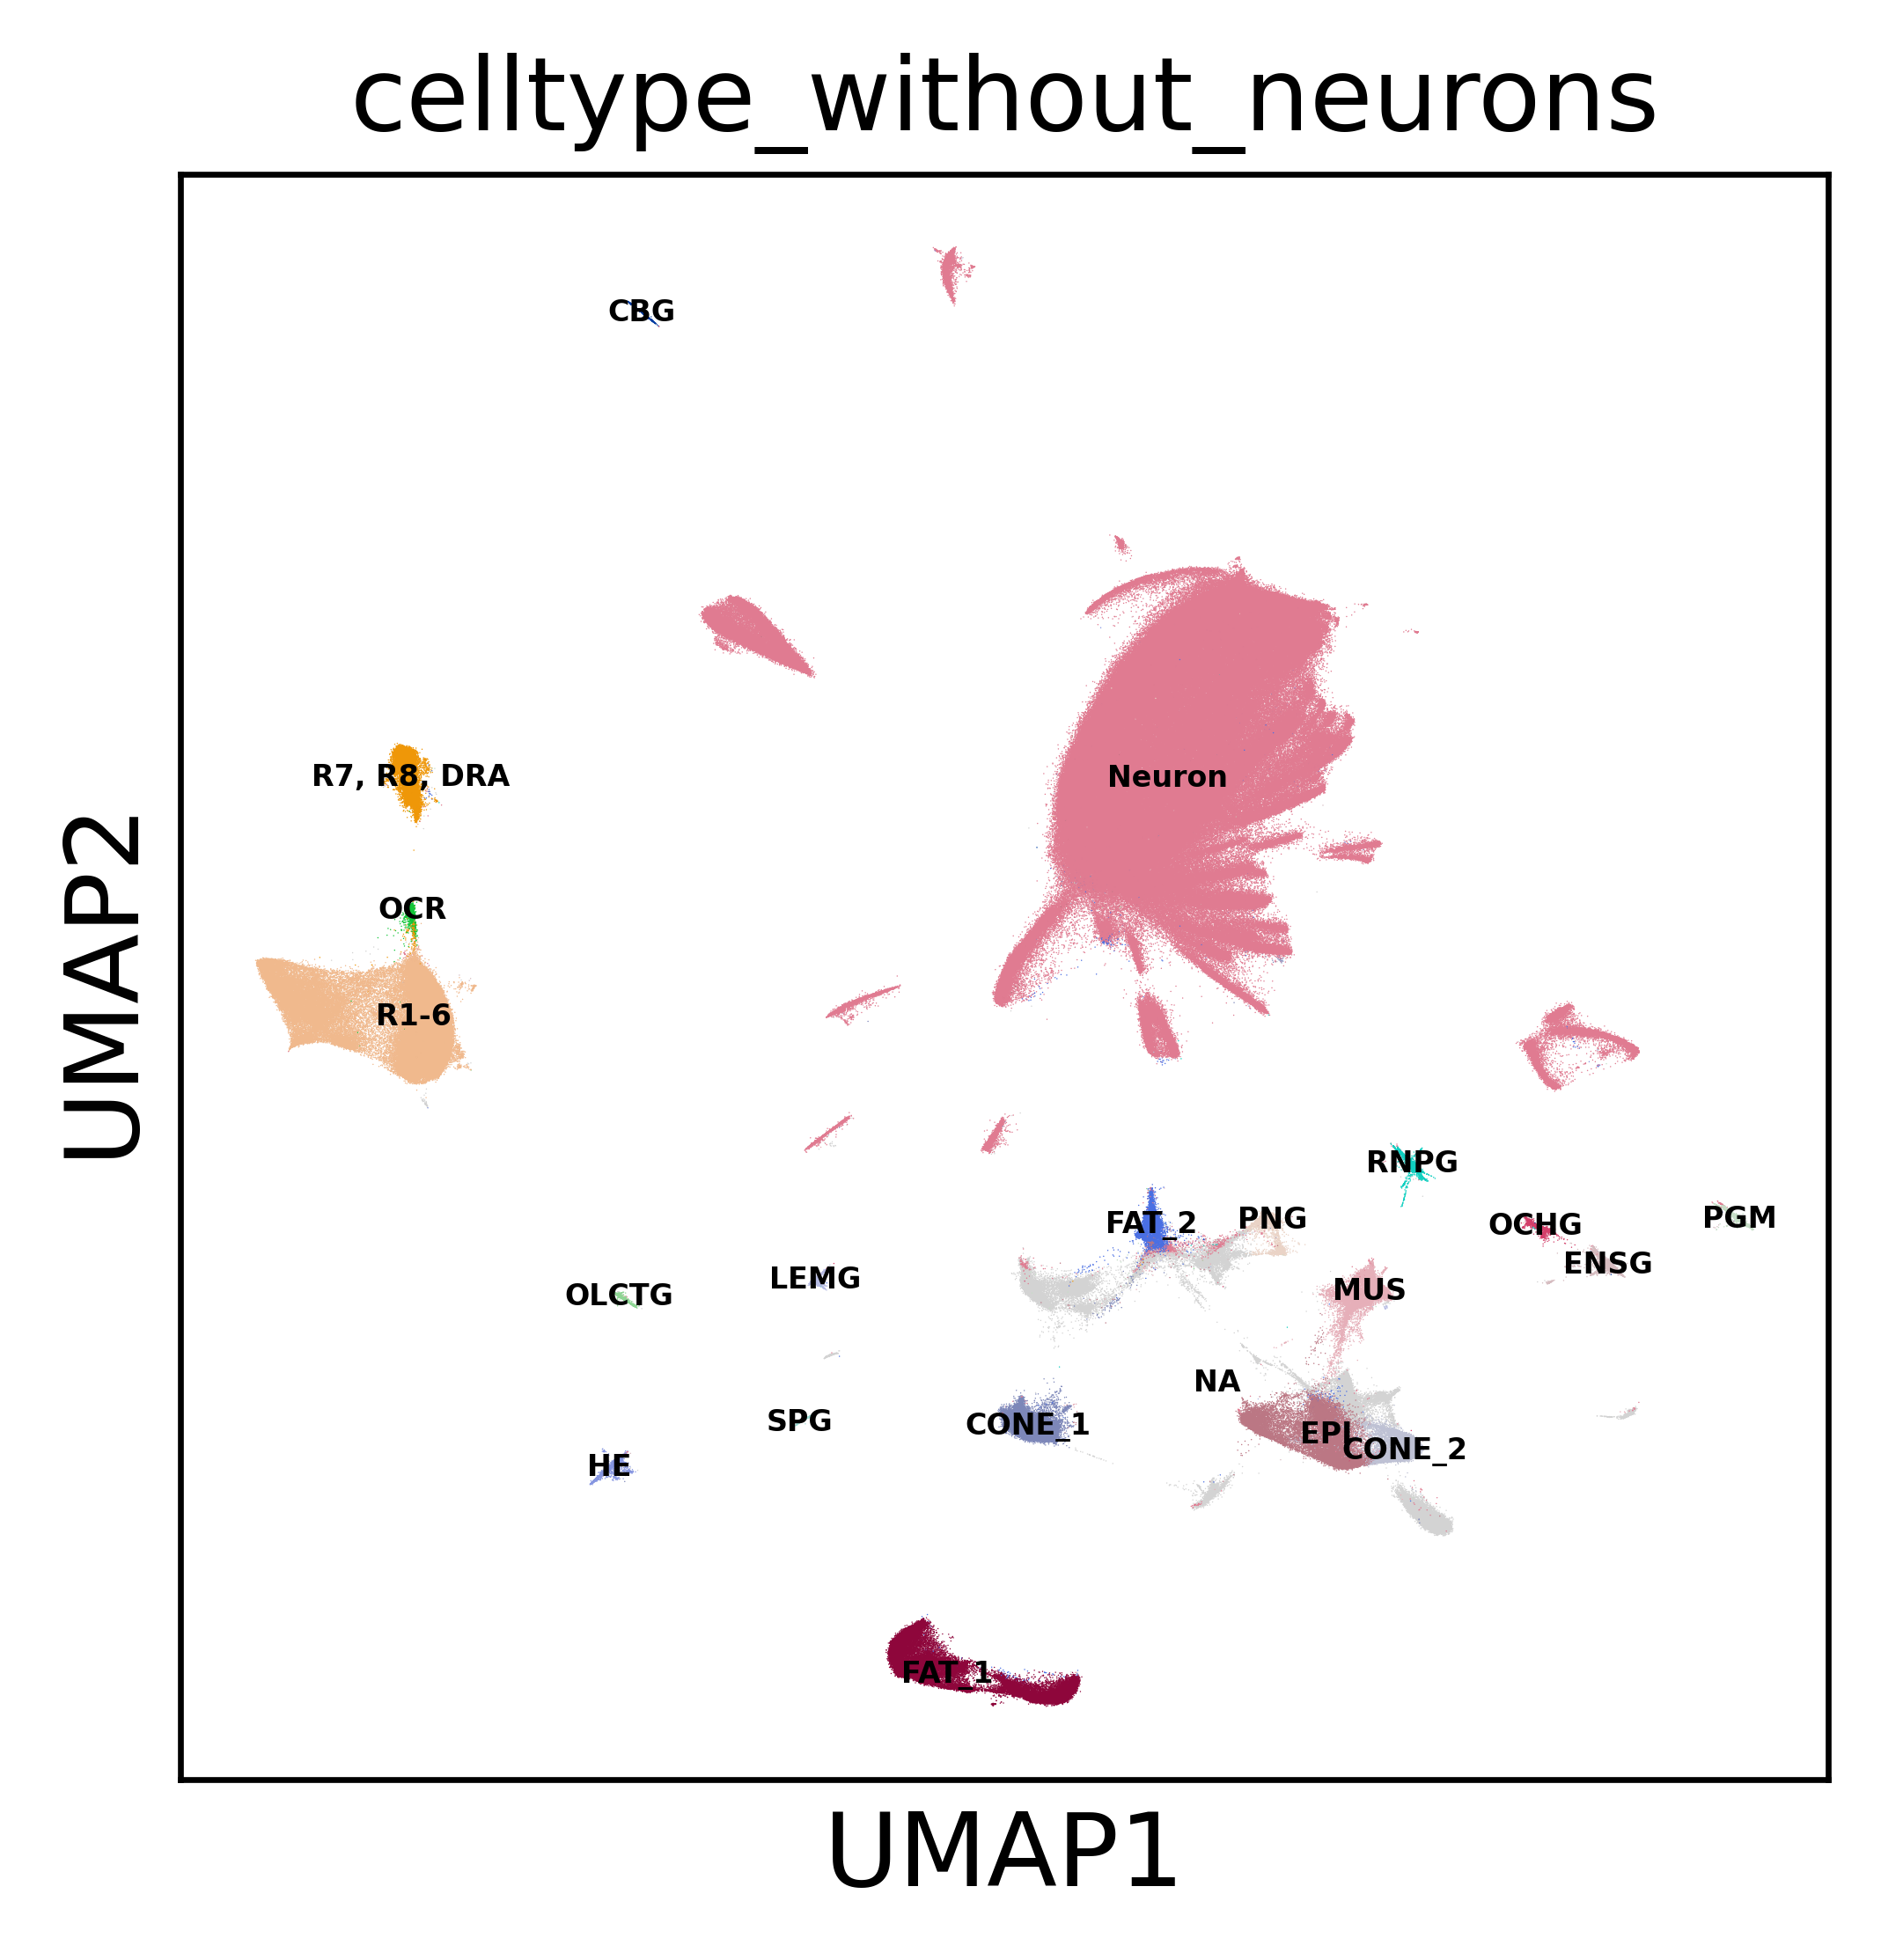

In [279]:
sc.pl.umap(adata, color = 'celltype_without_neurons', legend_loc = 'on data', legend_fontsize=4)

In [271]:
adata.obs.loc[adata.obs['main_celltype'] == 'Neuron', 'celltype_without_neurons'] = 'Neuron'

In [278]:
adata.obs.loc[adata.obs['celltype_without_neurons'] == 'nan', 'celltype_without_neurons'] = np.nan

# Subsetting the neuron cluster

In [2]:
adata = sc.read_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [186]:
adata_neuron = adata[adata.obs['main_celltype'] == 'Neuron'].copy()

In [189]:
adata_neuron.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet_neuron.h5ad")

/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


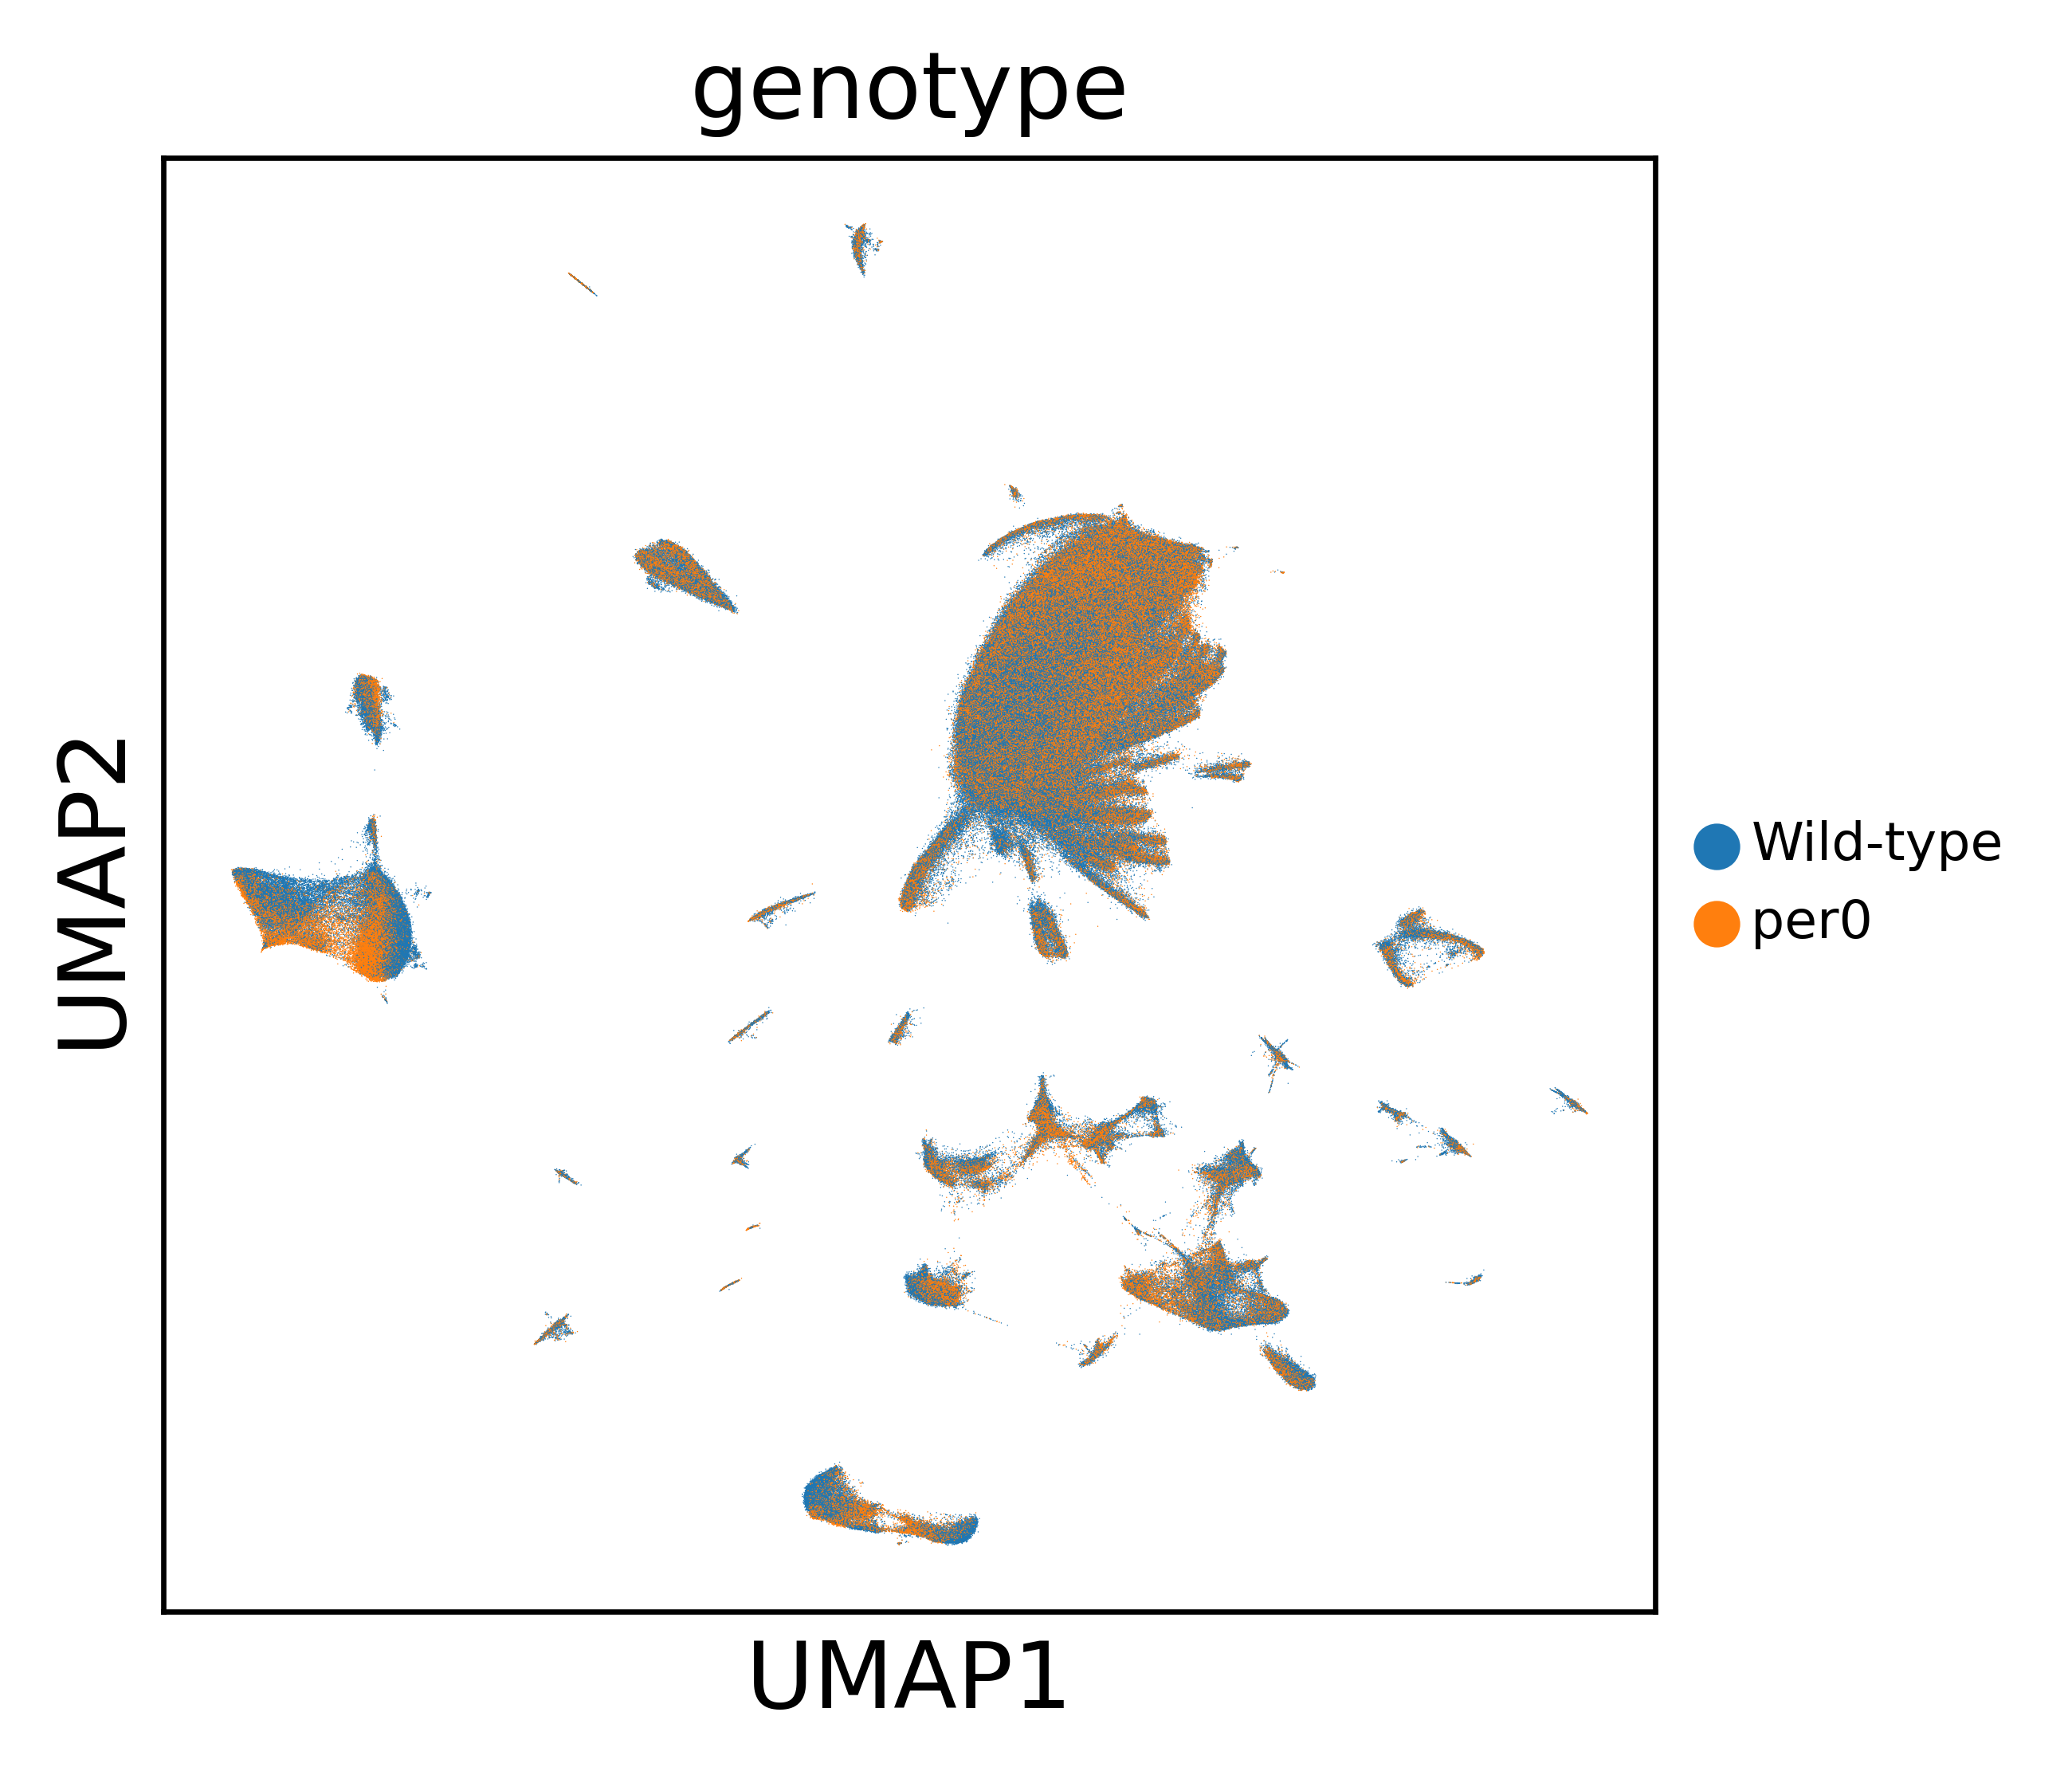

In [15]:
sc.pl.umap(adata, color = 'genotype', legend_fontsize=8)

/tmp/ipykernel_44986/1758835687.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs['all_celltype'][adata.obs['all_celltype'] == "nan"] = np.nan
/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/sc

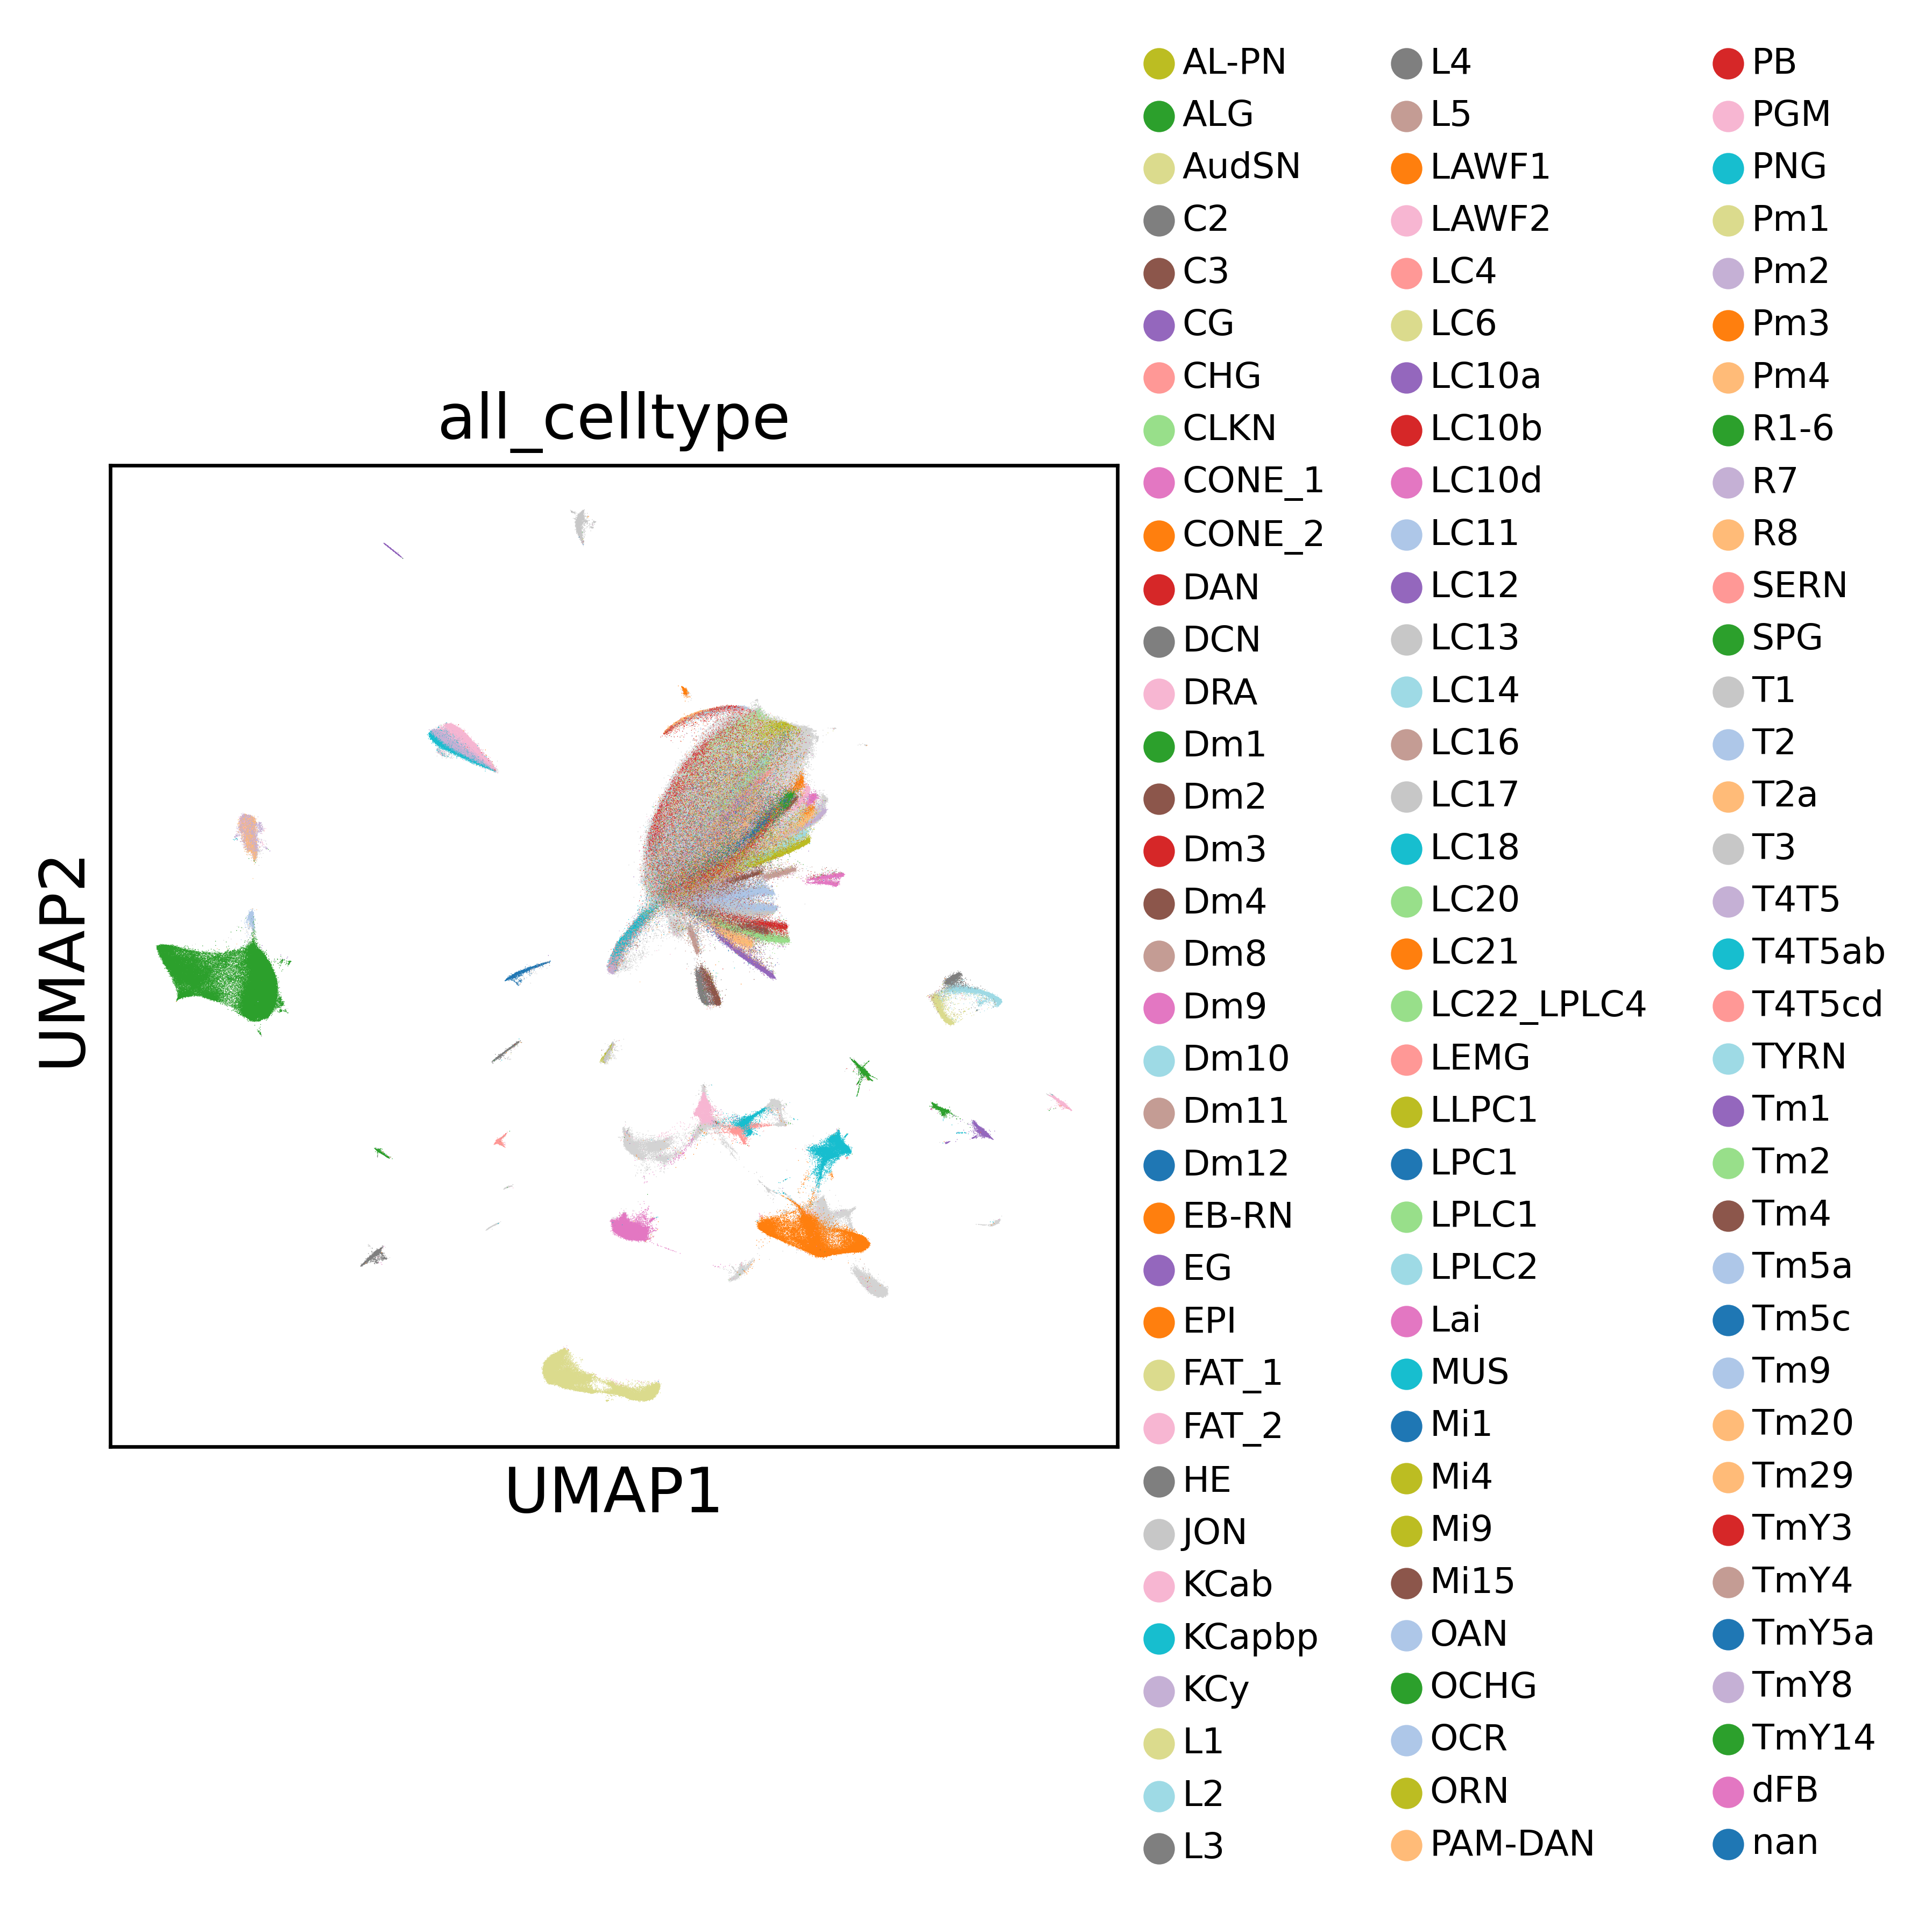

In [20]:
adata.obs['all_celltype'][adata.obs['all_celltype'] == "nan"] = np.nan
sc.pl.umap(adata, color = 'all_celltype', legend_fontsize=8, na_in_legend=False)

In [38]:
bdata = sc.read_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet_neuron.h5ad")

# Plugging in the neuronal celltypes to the whole data

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os

In [2]:
adata = sc.read_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [126]:
bdata = sc.read_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet_neuron.h5ad")

In [115]:
bdata.write_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet_neuron.h5ad")

In [109]:
bdata

AnnData object with n_obs × n_vars = 659684 × 17893
    obs: 'sample', 'Unmatched_rate', 'UMI_count', 'Gene_count', 'PCR_batch', 'Ligation_barcodes', 'ShortdT_UMI_count', 'RandomN_UMI_count', 'RT_barcodes_shortdT', 'Plate_ID', 'order_bc', 'row', 'col', 'barcode', 'Conditions', 'priming', 'sample.1', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'RT_barcode', 'doublet_scores', 'doublet', 'unsup_celltype', 'sex', 'genotype', 'light_condition', 'batch', 'replicate', 'new_Conditions', 'timepoint', 'new_timepoint', 'final_Conditions', 'main_celltype', 'celltype_without_neurons', 'neuron_celltype', 'UMAP_1_neuron', 'UMAP_2_neuron', 'leiden_res_0.20_neuron', 'leiden_res_0.40_neuron', 'leiden_res_0.60_neuron', 'leiden_res_0.80_neuron', 'leiden_res_1.00_neuron', 'leiden_res_1.20_neuron', 'leiden_res_1.40_neuron', 'leiden_res_1.60_neur

In [110]:
# Retrieve the 2D array of UMAP coordinates
umap_coords = bdata.obsm["X_umap"]
bdata.obs["UMAP_1_neuron"] = umap_coords[:, 0]
bdata.obs["UMAP_2_neuron"] = umap_coords[:, 1]

In [15]:
import pandas as pd

bdata.obs['neuron_celltype'] = bdata.obs['neuron_celltype'].astype(str)
adata.obs['all_celltype'] = adata.obs['all_celltype'].astype(str)

# Ensure sample names are aligned
matching_barcodes = adata.obs['sample'][adata.obs['sample'].isin(bdata.obs['sample'])]

# Create a mapping from integrated_ozel_adata to adata
barcode_to_annotation = bdata.obs['neuron_celltype'].reindex(matching_barcodes.index)

# Assign the new annotations to adata.obs
adata.obs.loc[barcode_to_annotation.index, 'all_celltype'] = barcode_to_annotation


In [12]:
adata.obs['all_celltype'] = adata.obs['celltype_without_neurons'].copy()

In [28]:
adata.obs['all_celltype'] = adata.obs['all_celltype'].astype(str)

adata.obs['all_celltype'][adata.obs['all_celltype'] == 'Neuron'] = np.nan
#adata.obs.loc(adata.obs['all_celltype'] == 'Neuron', 'all_celltype') = np.nan

/tmp/ipykernel_46408/1832308652.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs['all_celltype'][adata.obs['all_celltype'] == 'Neuron'] = np.nan
/tmp/ipykernel_46408/1832308652.py:3: SettingWithCopyWarning: 
A value is trying to

In [161]:
adata.obs.loc[adata.obs['celltype_without_neurons'] == 'Unknown', 'celltype_without_neurons'] = np.nan

In [165]:
import seaborn as sns

# Get all unique categories
cell_types = adata.obs['celltype_without_neurons'].astype(str).unique()

# Generate a color palette with distinct colors
palette = sns.color_palette("tab20", len(cell_types))

# Create a dictionary mapping cell types to colors
celltype_colors = dict(zip(cell_types, palette))

# Assign a neutral color to unknown or missing values
celltype_colors.setdefault("Unknown", "#d3d3d3")  # Light gray for 'Unknown'
celltype_colors.setdefault("", "#d3d3d3")         # Also handle empty strings


'#d3d3d3'

/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ru-auth/local/home/pkim/miniconda3/envs/workshop_2024/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


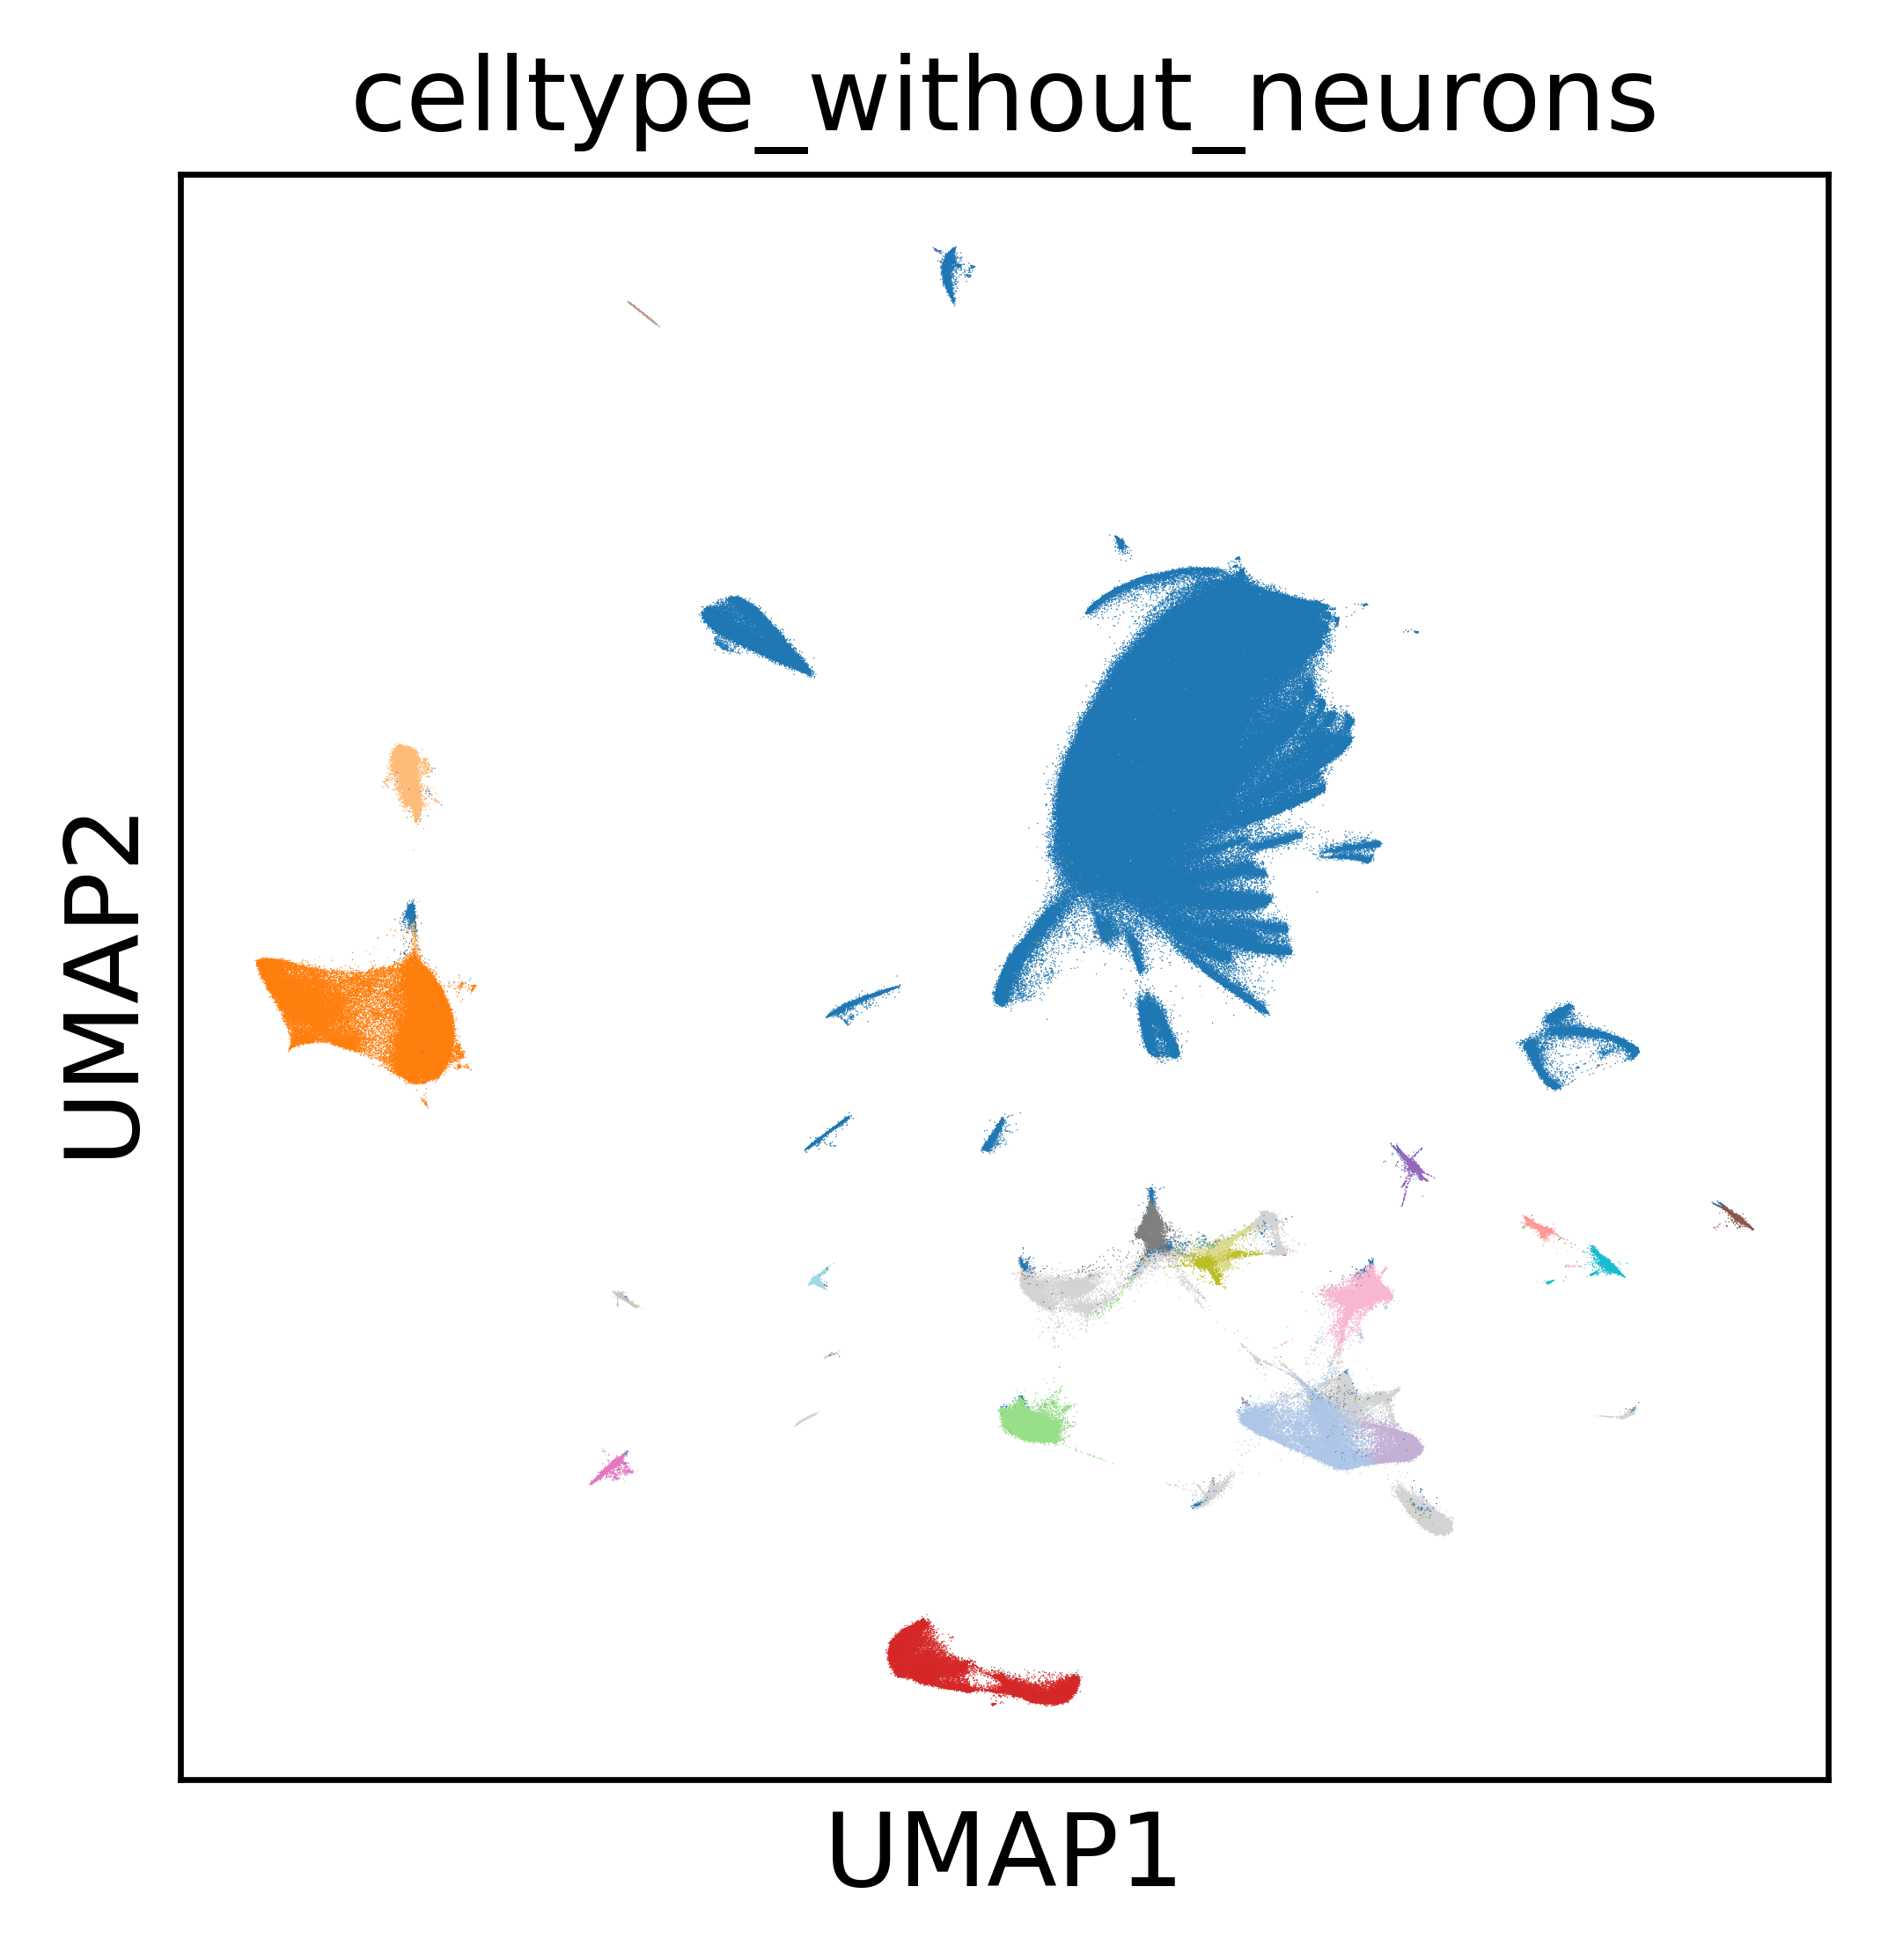

In [166]:
sc.pl.umap(adata, color='celltype_without_neurons', palette=celltype_colors, 
           legend_loc=None, na_in_legend=False, legend_fontsize=5)


In [7]:
adata.obs['all_celltype'] = adata.obs['all_celltype'].astype(str)

adata.obs['all_celltype'][adata.obs['all_celltype'] == 'Unknown'] = np.nan
#adata.obs.loc(adata.obs['all_celltype'] == 'Neuron', 'all_celltype') = np.nan

/tmp/ipykernel_55810/3888423783.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs['all_celltype'][adata.obs['all_celltype'] == 'Unknown'] = np.nan
/tmp/ipykernel_55810/3888423783.py:3: SettingWithCopyWarning: 
A value is trying t

# For Seurat Conversion

In [2]:
import scanpy as sc

In [3]:
adata = sc.read_h5ad("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad")

In [10]:
#adata.write_h5ad('/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:22/all_data_combined_post_scrublet.h5ad')

In [11]:
adata

AnnData object with n_obs × n_vars = 1001359 × 17198
    obs: 'sample', 'Unmatched_rate', 'UMI_count', 'Gene_count', 'PCR_batch', 'Ligation_barcodes', 'ShortdT_UMI_count', 'RandomN_UMI_count', 'RT_barcodes_shortdT', 'Plate_ID', 'order_bc', 'row', 'col', 'barcode', 'Conditions', 'priming', 'sample.1', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'RT_barcode', 'doublet_scores', 'doublet', 'unsup_celltype', 'sex', 'genotype', 'light_condition', 'batch', 'replicate', 'new_Conditions', 'timepoint', 'new_timepoint', 'final_Conditions', 'main_celltype', 'celltype_without_neurons', 'leiden_res_4.00_main', 'leiden_res_0.60_main', 'leiden_res_0.10_main', 'leiden_res_0.03_main', 'leiden_res_8.00_main', 'UMAP_1', 'UMAP_2', 'leiden_res_2.00_main', 'all_celltype', 'neuron_celltype', 'UMAP_1_neuron', 'UMAP_2_neuron', 'leiden_res_4.00_neuro

In [8]:
adata.obs['all_celltype'] = adata.obs['all_celltype'].replace({
    'FAT_1': 'FAT-1',
    'FAT_2': 'FAT-2',
    'CONE_1': 'CONE-1',
    'CONE_2': 'CONE-2',
    'LC22_LPLC4': 'LC22-LPLC4',
    'nan': 'Unannotated'
})

/tmp/ipykernel_13440/2598939620.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['all_celltype'] = adata.obs['all_celltype'].replace({


In [9]:
print(adata.obs['all_celltype'].unique().tolist())

['Unannotated', 'Tm5a', 'R1-6', 'R7', 'Lai', 'TmY3', 'CONE-1', 'EPI', 'FAT-1', 'T4T5', 'OCHG', 'TmY4', 'LC12', 'JON', 'T1', 'AL-PN', 'L3', 'T4T5ab', 'LC17', 'LPLC2', 'Tm9', 'LC4', 'ALG', 'TmY14', 'CONE-2', 'PGM', 'LC10a', 'Tm1', 'L2', 'CG', 'EB-RN', 'Mi1', 'KCab', 'KCapbp', 'Mi15', 'HE', 'Mi4', 'MUS', 'Mi9', 'T2', 'FAT-2', 'T2a', 'SPG', 'Tm2', 'DRA', 'T4T5cd', 'CLKN', 'R8', 'Dm9', 'Dm10', 'DAN', 'KCy', 'LAWF1', 'L5', 'T3', 'PAM-DAN', 'PNG', 'LC10b', 'L1', 'L4', 'EG', 'ORN', 'PB', 'Dm3', 'LLPC1', 'Dm8', 'LPC1', 'CHG', 'LC14', 'TmY8', 'Tm4', 'LAWF2', 'dFB', 'Dm2', 'C3', 'LC16', 'LPLC1', 'C2', 'LEMG', 'LC21', 'Dm12', 'TmY5a', 'OCR', 'Pm4', 'Tm20', 'AudSN', 'LC22-LPLC4', 'LC11', 'SERN', 'LC10d', 'Pm3', 'Dm4', 'LC18', 'Dm11', 'LC6', 'Dm1', 'LC20', 'OAN', 'Pm2', 'Pm1', 'TYRN', 'Tm5c', 'LC13', 'DCN', 'Tm29']


In [12]:
import pandas as pd
import scipy.io
import scipy.sparse

# Export the expression matrix as .mtx
scipy.io.mmwrite("adata_matrix.mtx", adata.X)
# Export cell metadata (observations)
adata.obs.to_csv("df_cell.csv")
# Export gene metadata (variables)
adata.var.to_csv("df_gene.csv")

In [ ]:
del adata.obs['leiden_res_10.00_main']
del adata.obs['leiden_res_12.00_main']
del adata.obs['leiden_res_14.00_main']
del adata.obs['leiden_res_18.00_main']
del adata.obs['leiden_res_20.00_main']
del adata.obs['leiden_res_25.00_main']
del adata.obs['leiden_res_50.00_main']
del adata.obs['leiden_res_75.00_main']
del adata.obs['leiden_res_100.00_main']
del adata.uns['leiden_res_12.00_main_colors']
del adata.uns['leiden_res_14.00_main_colors']
del adata.uns['leiden_res_16.00_main_colors']
del adata.uns['leiden_res_25.00_main_colors']
del adata.uns['leiden_res_50.00_main_colors']